# PJM Baseline Forecast Exploration

In [7]:
import os
from datetime import date, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error

# === Weather loading (temperature only) from Meteostat ===
# - One representative city per zone (first row in data/zone_city_zip.csv)
# - Cached per (zone, year) under data/weather_cities
# - Timezone: America/New_York, aligned with PJM EPT

import datetime as dt
from pathlib import Path

import pgeocode
from meteostat import Point, Hourly


## Configuration

In [8]:
import os
from pathlib import Path
from datetime import date, timedelta
import pandas as pd

# Directories (work both locally and in Docker)
DATA_DIR = Path(os.environ.get("DATA_DIR", "data"))
WEATHER_DIR = Path(os.environ.get("WEATHER_DIR", "data/weather_cities"))

print("Using DATA_DIR:", DATA_DIR.resolve())
print("Using WEATHER_DIR:", WEATHER_DIR.resolve())

# File names (strings, like in your original code)
TRAIN_FILES = [
    "hrl_load_metered_2016.csv",
    "hrl_load_metered_2017.csv",
    "hrl_load_metered_2018.csv",
    "hrl_load_metered_2019.csv",
    "hrl_load_metered_2020.csv",
    "hrl_load_metered_2021.csv",
    "hrl_load_metered_2022.csv",
    "hrl_load_metered_2023.csv",
]

PREDICT_YEAR = 2024

# The 2024 evaluation file (single-year, as in the original code)
EVAL_FILE = f"hrl_load_metered_{PREDICT_YEAR}.csv"

TRAIN_START = date(2016, 1, 1)
TRAIN_END   = date(2023, 12, 31)

# Your 10-day Thanksgiving window (this matches the notebook you uploaded)
def thanksgiving_date(year: int) -> date:
    nov_first = date(year, 11, 1)
    first_thursday = nov_first + timedelta(days=(3 - nov_first.weekday()) % 7)
    return first_thursday + timedelta(weeks=3)

PREDICT_START = thanksgiving_date(PREDICT_YEAR) - timedelta(days=7)
PREDICT_END   = thanksgiving_date(PREDICT_YEAR) + timedelta(days=2)

print("PREDICT_START:", PREDICT_START)
print("PREDICT_END  :", PREDICT_END)


Using DATA_DIR: /Users/ywtseng/Desktop/604proj4/data
Using WEATHER_DIR: /Users/ywtseng/Desktop/604proj4/data/weather_cities
PREDICT_START: 2024-11-21
PREDICT_END  : 2024-11-30


## Helpers

In [9]:
def thanksgiving_date(year: int) -> date:
    nov_first = date(year, 11, 1)
    first_thursday = nov_first + timedelta(days=(3 - nov_first.weekday()) % 7)
    return first_thursday + timedelta(weeks=3)

def load_training_data() -> pd.DataFrame:
    frames = []
    for fname in TRAIN_FILES:
        path = DATA_DIR / fname
        if not path.exists():
            print(f"[load_training_data] WARNING: {path} does not exist, skipping.")
            continue

        df = pd.read_csv(
            path,
            usecols=["datetime_beginning_ept", "load_area", "mw"],
        )
        frames.append(df)

    if not frames:
        raise RuntimeError("[load_training_data] No training CSVs found in TRAIN_FILES.")

    train_df = pd.concat(frames, ignore_index=True)

    # Drop RTO aggregate – work only with zones
    train_df = train_df[train_df["load_area"] != "RTO"].copy()

    ts = pd.to_datetime(
        train_df["datetime_beginning_ept"],
        format="%m/%d/%Y %I:%M:%S %p",
        errors="raise",
    )
    train_df["timestamp"] = ts
    train_df["date"] = ts.dt.date
    train_df["hour"] = ts.dt.hour
    train_df["dow"] = ts.dt.dayofweek
    train_df["month"] = ts.dt.month
    train_df["year"] = ts.dt.year

    mask = (train_df["date"] >= TRAIN_START) & (train_df["date"] <= TRAIN_END)
    train_df = train_df.loc[mask].copy()

    return train_df



def load_actuals_range(start_date: date, end_date: date) -> pd.DataFrame:
    path = DATA_DIR / EVAL_FILE
    if not path.exists():
        raise RuntimeError(f"[load_actuals_range] Evaluation file not found: {path}")

    df = pd.read_csv(
        path,
        usecols=["datetime_beginning_ept", "load_area", "mw"],
    )

    # Drop RTO here as well
    df = df[df["load_area"] != "RTO"].copy()

    ts = pd.to_datetime(
        df["datetime_beginning_ept"],
        format="%m/%d/%Y %I:%M:%S %p",
        errors="raise",
    )
    df["timestamp"] = ts
    df["date"] = ts.dt.date
    df["hour"] = ts.dt.hour
    df["dow"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    df["year"] = ts.dt.year

    mask = (df["date"] >= start_date) & (df["date"] <= end_date)
    actuals_df = df.loc[mask].copy()

    if actuals_df.empty:
        raise RuntimeError(
            f"[load_actuals_range] No rows in range {start_date} to {end_date} "
            f"from file {path}"
        )

    return actuals_df



HANUKKAH_START = {
    2016: date(2016, 12, 24),
    2017: date(2017, 12, 12),
    2018: date(2018, 12, 2),
    2019: date(2019, 12, 22),
    2020: date(2020, 12, 10),
    2021: date(2021, 11, 28),
    2022: date(2022, 12, 18),
    2023: date(2023, 12, 7),
    2024: date(2024, 12, 25),
}


def holiday_ranges(year: int):
    ranges = []
    ranges.append((date(year, 10, 27), date(year, 11, 3)))  # Halloween week
    tg = thanksgiving_date(year)
    ranges.append((tg - timedelta(days=3), tg + timedelta(days=4)))  # Mon before to Cyber Monday
    ranges.append((date(year, 12, 22), date(year, 12, 28)))  # Christmas window
    start = HANUKKAH_START.get(year)
    if start is not None:
        ranges.append((start - timedelta(days=1), start + timedelta(days=8)))
    ranges.append((date(year, 12, 29), date(year + 1, 1, 3)))  # New Year window
    return ranges

PREDICT_START = thanksgiving_date(PREDICT_YEAR) - timedelta(days=7)
PREDICT_END = thanksgiving_date(PREDICT_YEAR) + timedelta(days=2)


## Load Data

In [10]:
train_df = load_training_data()
actuals_full_df = load_actuals_range(date(2024, 10, 1), date(2025, 1, 31))
actuals_eval_df = actuals_full_df[(actuals_full_df["date"] >= PREDICT_START) & (actuals_full_df["date"] <= PREDICT_END)].copy()
print(f"Training rows: {len(train_df):,}; Eval rows: {len(actuals_eval_df):,}")
print("Unique load_area in eval:", sorted(actuals_eval_df["load_area"].unique()))
print("Number of load areas:", actuals_eval_df["load_area"].nunique())

# For 10 days * 24 hours * 29 zones, you should now see:
# nrows = 10 * 24 * 29 = 6960
print("Expected rows (10 days * 24 * 29):", 10 * 24 * 29)
print("Actual eval rows:", len(actuals_eval_df))


Training rows: 1,995,745; Eval rows: 6,960
Unique load_area in eval: ['AECO', 'AEPAPT', 'AEPIMP', 'AEPKPT', 'AEPOPT', 'AP', 'BC', 'CE', 'DAY', 'DEOK', 'DOM', 'DPLCO', 'DUQ', 'EASTON', 'EKPC', 'JC', 'ME', 'OE', 'OVEC', 'PAPWR', 'PE', 'PEPCO', 'PLCO', 'PN', 'PS', 'RECO', 'SMECO', 'UGI', 'VMEU']
Number of load areas: 29
Expected rows (10 days * 24 * 29): 6960
Actual eval rows: 6960


## Nov 20–29 Hourly Profiles

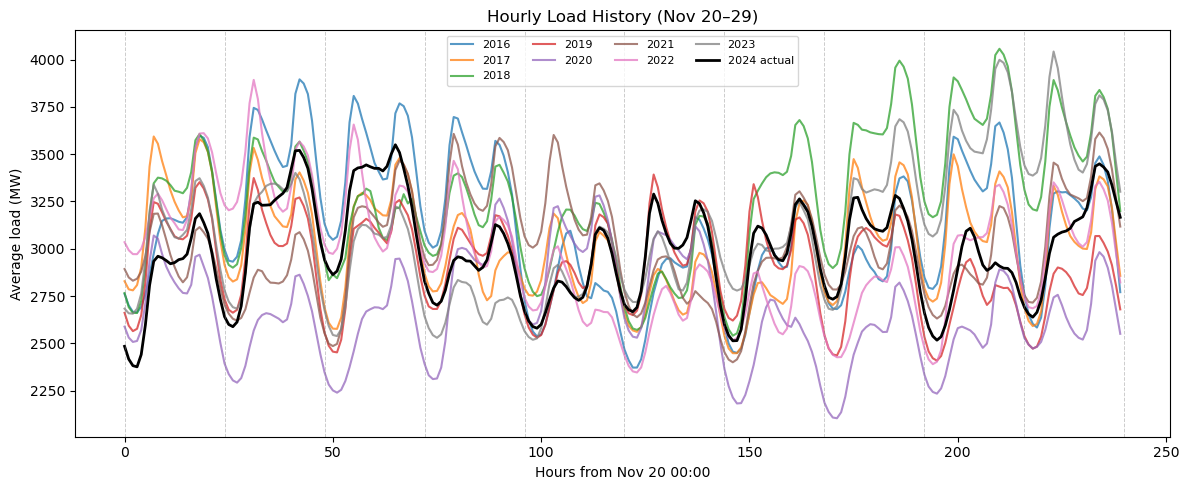

In [11]:

window_mask = (
    (train_df["timestamp"].dt.month == 11) &
    (train_df["timestamp"].dt.day >= 20) &
    (train_df["timestamp"].dt.day <= 29)
)
window_df = train_df.loc[window_mask].copy()
if window_df.empty:
    raise RuntimeError("No training rows for Nov 20–29 across historical years.")
window_df["year"] = window_df["timestamp"].dt.year
window_df["window_ref"] = pd.to_datetime(window_df["year"].astype(str) + "-11-20")
window_df["hours_from_start"] = (window_df["timestamp"] - window_df["window_ref"]).dt.total_seconds() / 3600.0
agg = window_df.groupby(["year", "hours_from_start"])["mw"].mean().reset_index()

plt.figure(figsize=(12, 5))
for year, grp in agg.groupby("year"):
    plt.plot(grp["hours_from_start"], grp["mw"], alpha=0.75, label=str(year))

actual_start = pd.Timestamp(f"{PREDICT_YEAR}-11-20")
actual_end = actual_start + pd.Timedelta(days=10)
actual_mask = (actuals_full_df["timestamp"] >= actual_start) & (actuals_full_df["timestamp"] < actual_end)
actual_plot = actuals_full_df.loc[actual_mask].copy()
if actual_plot.empty and not actuals_eval_df.empty:
    actual_plot = actuals_eval_df.copy()
if not actual_plot.empty:
    actual_plot["hours_from_start"] = (
        (actual_plot["timestamp"] - actual_start)
        .dt.total_seconds() / 3600.0
    )
    actual_agg = actual_plot.groupby("hours_from_start")["mw"].mean().reset_index()
    plt.plot(actual_agg["hours_from_start"], actual_agg["mw"], color="black", linewidth=2, label=f"{PREDICT_YEAR} actual")

plt.xlabel("Hours from Nov 20 00:00")
plt.ylabel("Average load (MW)")
plt.title("Hourly Load History (Nov 20–29)")
plt.legend(ncol=4, fontsize=8)

ax = plt.gca()
xmin, xmax = ax.get_xlim()
for h in range(0, int(xmax) + 1, 24):
    ax.axvline(h, linestyle='--', linewidth=0.7, color='gray', alpha=0.4)

plt.tight_layout()


## Thanksgiving-Aligned Profiles (2017–2024)

In [12]:
# thanksgiving of 2016-2025
for year in range(2016, 2026):
    tg_date = thanksgiving_date(year)
    print(f"Thanksgiving {year}: {tg_date}")

Thanksgiving 2016: 2016-11-24
Thanksgiving 2017: 2017-11-23
Thanksgiving 2018: 2018-11-22
Thanksgiving 2019: 2019-11-28
Thanksgiving 2020: 2020-11-26
Thanksgiving 2021: 2021-11-25
Thanksgiving 2022: 2022-11-24
Thanksgiving 2023: 2023-11-23
Thanksgiving 2024: 2024-11-28
Thanksgiving 2025: 2025-11-27


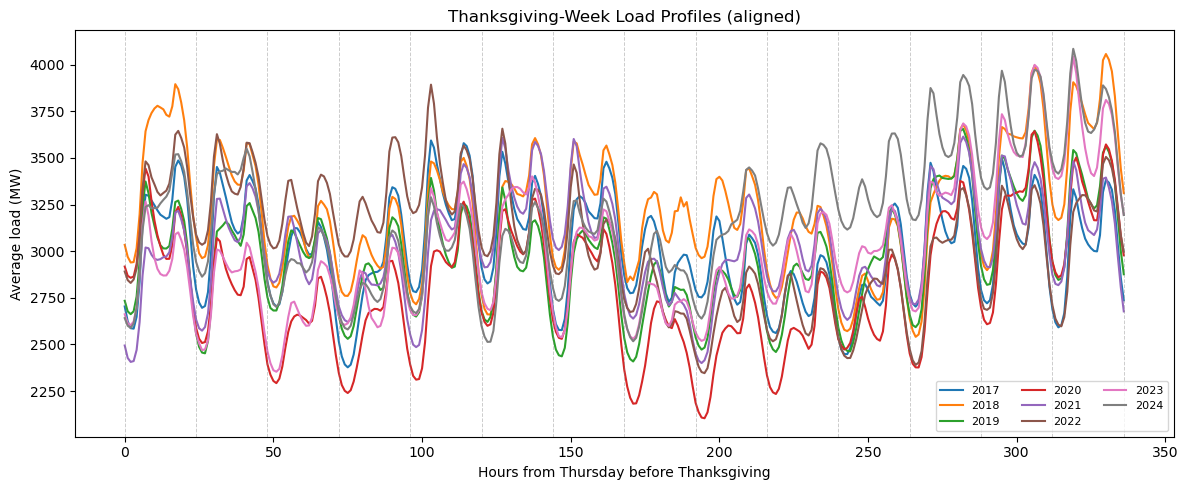

In [13]:

years = list(range(2017, 2025))
start_offsets = []
end_offsets = []
plt.figure(figsize=(12, 5))
for year in years:
    if year <= TRAIN_END.year:
        source = train_df[train_df["timestamp"].dt.year == year]
    else:
        source = actuals_full_df[actuals_full_df["timestamp"].dt.year == year]
    if source.empty:
        continue
    thanksgiving = thanksgiving_date(year)
    align_start = thanksgiving - timedelta(days=7)
    start_ts = pd.Timestamp(align_start)
    end_ts = start_ts + pd.Timedelta(days=14)
    slice_df = source[(source["timestamp"] >= start_ts) & (source["timestamp"] <= end_ts)].copy()
    if slice_df.empty:
        continue
    slice_df["hours_from_thu"] = (slice_df["timestamp"] - start_ts).dt.total_seconds() / 3600.0
    agg = slice_df.groupby("hours_from_thu")["mw"].mean().reset_index()
    plt.plot(agg["hours_from_thu"], agg["mw"], label=str(year))
    nov20 = pd.Timestamp(date(year, 11, 20))
    nov29 = pd.Timestamp(date(year, 11, 29)) + pd.Timedelta(days=1)
    start_offsets.append((nov20 - start_ts).days * 24)
    end_offsets.append((nov29 - start_ts).days * 24)

ax = plt.gca()
xmin, xmax = ax.get_xlim()
for h in range(0, int(xmax) + 1, 24):
    ax.axvline(h, linestyle='--', linewidth=0.7, color='gray', alpha=0.4)

plt.xlabel("Hours from Thursday before Thanksgiving")
plt.ylabel("Average load (MW)")
plt.title("Thanksgiving-Week Load Profiles (aligned)")
plt.legend(ncol=3, fontsize=8)


plt.tight_layout()


## Regular Oct–Jan Weeks (Non-holiday)

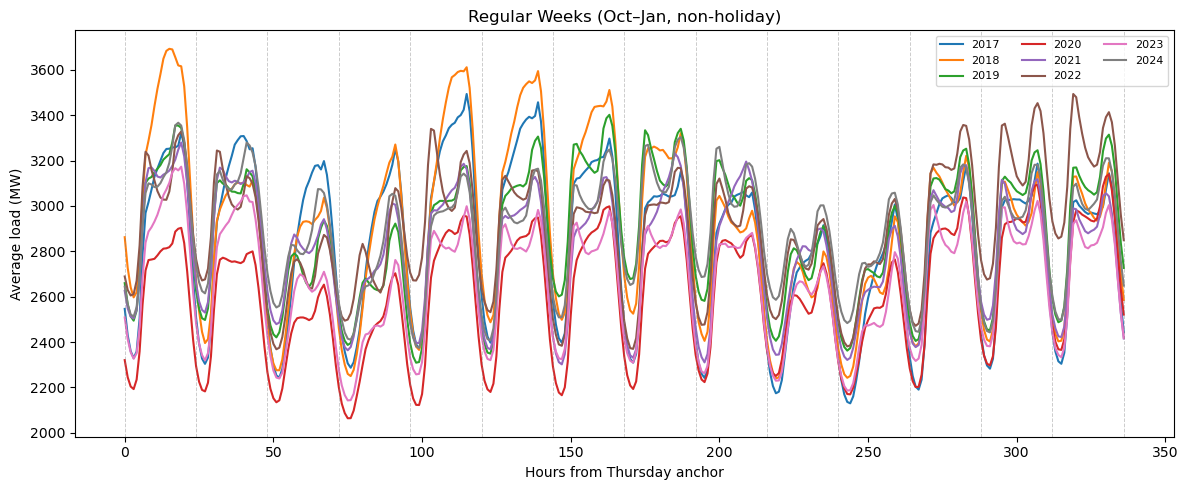

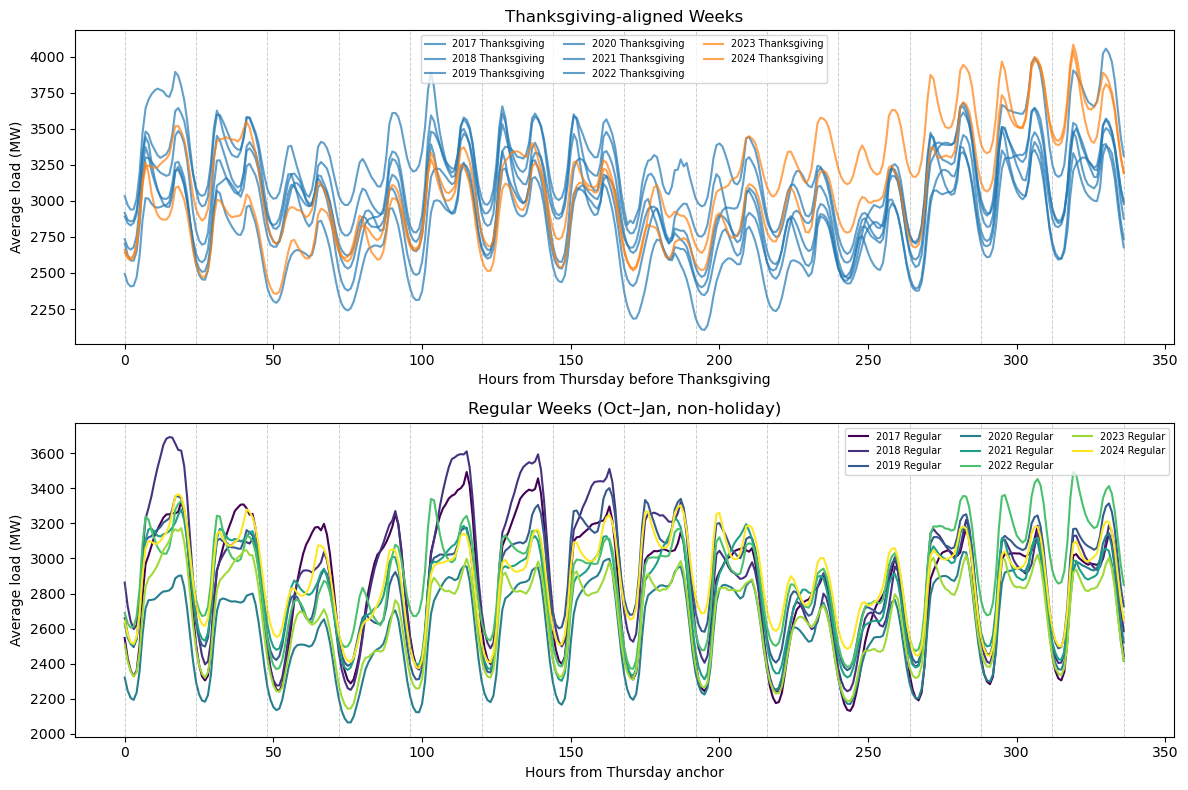

In [14]:

years = list(range(2017, 2025))
plt.figure(figsize=(12, 5))
for year in years:
    if year <= TRAIN_END.year:
        source = train_df[train_df["timestamp"].dt.year == year]
    else:
        source = actuals_full_df[actuals_full_df["timestamp"].dt.year == year]
    if source.empty:
        continue
    ranges = holiday_ranges(year)
    start_date = date(year, 10, 1)
    end_date = date(year + 1, 1, 31)
    d = start_date + timedelta(days=(3 - start_date.weekday()) % 7)  # first Thursday
    segments = []
    while d <= end_date:
        window_start = pd.Timestamp(d)
        window_end = window_start + pd.Timedelta(days=14)
        window_range = (window_start.date(), window_end.date())
        overlap = False
        for r_start, r_end in ranges:
            if window_range[0] <= r_end and window_range[1] >= r_start:
                overlap = True
                break
        if overlap:
            d += timedelta(days=7)
            continue
        slice_df = source[(source["timestamp"] >= window_start) & (source["timestamp"] <= window_end)].copy()
        if slice_df.empty:
            d += timedelta(days=7)
            continue
        slice_df["hours_from_thu"] = (slice_df["timestamp"] - window_start).dt.total_seconds() / 3600.0
        segments.append(slice_df.groupby("hours_from_thu")["mw"].mean().reset_index())
        d += timedelta(days=7)
    if not segments:
        continue
    avg_segment = pd.concat(segments).groupby("hours_from_thu")["mw"].mean().reset_index()
    plt.plot(avg_segment["hours_from_thu"], avg_segment["mw"], label=str(year))

ax = plt.gca()
xmin, xmax = ax.get_xlim()
for h in range(0, int(xmax) + 1, 24):
    ax.axvline(h, linestyle='--', linewidth=0.7, color='gray', alpha=0.4)

plt.xlabel("Hours from Thursday anchor")
plt.ylabel("Average load (MW)")
plt.title("Regular Weeks (Oct–Jan, non-holiday)")
plt.legend(ncol=3, fontsize=8)

plt.tight_layout()



# Combined Thanksgiving vs Regular Weeks plot
plt.figure(figsize=(12, 8))
# Top subplot: Thanksgiving-aligned
plt.subplot(2, 1, 1)
years = list(range(2017, 2025))
for year in years:
    if year <= TRAIN_END.year:
        source = train_df[train_df['timestamp'].dt.year == year]
    else:
        source = actuals_full_df[actuals_full_df['timestamp'].dt.year == year]
    if source.empty:
        continue
    thanksgiving = thanksgiving_date(year)
    align_start = thanksgiving - timedelta(days=7)
    start_ts = pd.Timestamp(align_start)
    slice_df = source[(source['timestamp'] >= start_ts) & (source['timestamp'] <= start_ts + pd.Timedelta(days=14))].copy()
    if slice_df.empty:
        continue
    slice_df['hours_from_thu'] = (slice_df['timestamp'] - start_ts).dt.total_seconds() / 3600.0
    agg = slice_df.groupby('hours_from_thu')['mw'].mean().reset_index()
    color = 'tab:orange' if year >= 2023 else 'tab:blue'
    plt.plot(agg['hours_from_thu'], agg['mw'], label=f"{year} Thanksgiving", alpha=0.7, color=color)

ax = plt.gca()
xmin, xmax = ax.get_xlim()
for h in range(0, int(xmax) + 1, 24):
    ax.axvline(h, linestyle='--', linewidth=0.7, color='gray', alpha=0.4)

plt.xlabel('Hours from Thursday before Thanksgiving')
plt.ylabel('Average load (MW)')
plt.title('Thanksgiving-aligned Weeks')
plt.legend(ncol=3, fontsize=7)

# Bottom subplot: Regular weeks
plt.subplot(2, 1, 2)
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))
for color, year in zip(colors, years):
    if year <= TRAIN_END.year:
        source = train_df[train_df['timestamp'].dt.year == year]
    else:
        source = actuals_full_df[actuals_full_df['timestamp'].dt.year == year]
    if source.empty:
        continue
    ranges = holiday_ranges(year)
    start_date = date(year, 10, 1)
    end_date = date(year + 1, 1, 31)
    d = start_date + timedelta(days=(3 - start_date.weekday()) % 7)
    segments = []
    while d <= end_date:
        window_start = pd.Timestamp(d)
        window_end = window_start + pd.Timedelta(days=14)
        window_range = (window_start.date(), window_end.date())
        overlap = False
        for r_start, r_end in ranges:
            if window_range[0] <= r_end and window_range[1] >= r_start:
                overlap = True
                break
        if overlap:
            d += timedelta(days=7)
            continue
        slice_df = source[(source['timestamp'] >= window_start) & (source['timestamp'] <= window_end)].copy()
        if slice_df.empty:
            d += timedelta(days=7)
            continue
        slice_df['hours_from_thu'] = (slice_df['timestamp'] - window_start).dt.total_seconds() / 3600.0
        segments.append(slice_df.groupby('hours_from_thu')['mw'].mean().reset_index())
        d += timedelta(days=7)
    if not segments:
        continue
    avg_segment = pd.concat(segments).groupby('hours_from_thu')['mw'].mean().reset_index()
    plt.plot(avg_segment['hours_from_thu'], avg_segment['mw'], label=f"{year} Regular", color=color)

ax = plt.gca()
xmin, xmax = ax.get_xlim()
for h in range(0, int(xmax) + 1, 24):
    ax.axvline(h, linestyle='--', linewidth=0.7, color='gray', alpha=0.4)

plt.xlabel('Hours from Thursday anchor')
plt.ylabel('Average load (MW)')
plt.title('Regular Weeks (Oct–Jan, non-holiday)')
plt.legend(ncol=3, fontsize=7)
plt.tight_layout()


## Post-COVID Thanksgiving vs Regular Weeks (2021–2024)

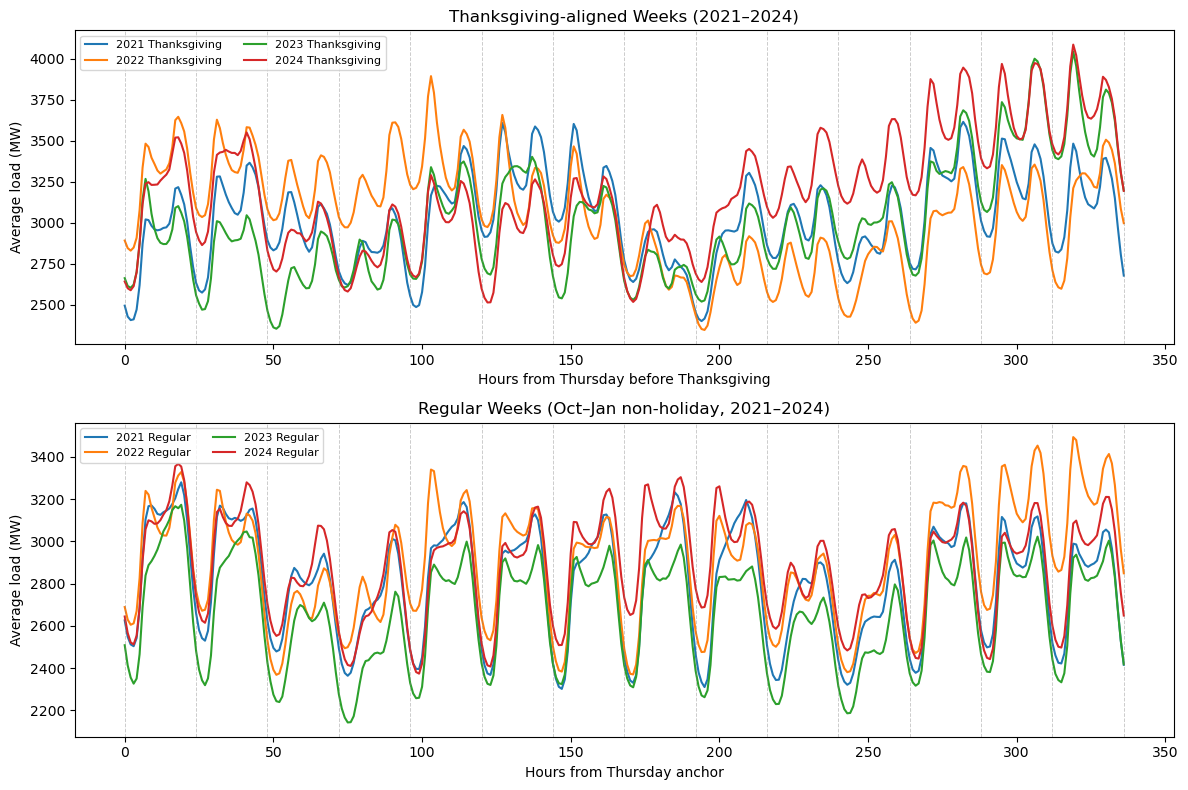

In [15]:

post_covid_years = list(range(2021, 2025))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for year in post_covid_years:
    if year <= TRAIN_END.year:
        source = train_df[train_df['timestamp'].dt.year == year]
    else:
        source = actuals_full_df[actuals_full_df['timestamp'].dt.year == year]
    if source.empty:
        continue
    thanksgiving = thanksgiving_date(year)
    align_start = thanksgiving - timedelta(days=7)
    start_ts = pd.Timestamp(align_start)
    slice_df = source[(source['timestamp'] >= start_ts) & (source['timestamp'] <= start_ts + pd.Timedelta(days=14))].copy()
    if slice_df.empty:
        continue
    slice_df['hours_from_thu'] = (slice_df['timestamp'] - start_ts).dt.total_seconds() / 3600.0
    agg = slice_df.groupby('hours_from_thu')['mw'].mean().reset_index()
    plt.plot(agg['hours_from_thu'], agg['mw'], label=f"{year} Thanksgiving")

ax = plt.gca()
xmin, xmax = ax.get_xlim()
for h in range(0, int(xmax) + 1, 24):
    ax.axvline(h, linestyle='--', linewidth=0.7, color='gray', alpha=0.4)

plt.title('Thanksgiving-aligned Weeks (2021–2024)')
plt.xlabel('Hours from Thursday before Thanksgiving')
plt.ylabel('Average load (MW)')
plt.legend(ncol=2, fontsize=8)

plt.subplot(2, 1, 2)
for year in post_covid_years:
    if year <= TRAIN_END.year:
        source = train_df[train_df['timestamp'].dt.year == year]
    else:
        source = actuals_full_df[actuals_full_df['timestamp'].dt.year == year]
    if source.empty:
        continue
    ranges = holiday_ranges(year)
    start_date = date(year, 10, 1)
    end_date = date(year + 1, 1, 31)
    d = start_date + timedelta(days=(3 - start_date.weekday()) % 7)
    segments = []
    while d <= end_date:
        window_start = pd.Timestamp(d)
        window_end = window_start + pd.Timedelta(days=14)
        window_range = (window_start.date(), window_end.date())
        overlap = False
        for r_start, r_end in ranges:
            if window_range[0] <= r_end and window_range[1] >= r_start:
                overlap = True
                break
        if overlap:
            d += timedelta(days=7)
            continue
        slice_df = source[(source['timestamp'] >= window_start) & (source['timestamp'] <= window_end)].copy()
        if slice_df.empty:
            d += timedelta(days=7)
            continue
        slice_df['hours_from_thu'] = (slice_df['timestamp'] - window_start).dt.total_seconds() / 3600.0
        segments.append(slice_df.groupby('hours_from_thu')['mw'].mean().reset_index())
        d += timedelta(days=7)
    if not segments:
        continue
    avg_segment = pd.concat(segments).groupby('hours_from_thu')['mw'].mean().reset_index()
    plt.plot(avg_segment['hours_from_thu'], avg_segment['mw'], label=f"{year} Regular")

ax = plt.gca()
xmin, xmax = ax.get_xlim()
for h in range(0, int(xmax) + 1, 24):
    ax.axvline(h, linestyle='--', linewidth=0.7, color='gray', alpha=0.4)

plt.title('Regular Weeks (Oct–Jan non-holiday, 2021–2024)')
plt.xlabel('Hours from Thursday anchor')
plt.ylabel('Average load (MW)')
plt.legend(ncol=2, fontsize=8)


plt.tight_layout()


## Baseline Variants RMSE

Training time period:
- 2016-2023
- 2020-2023
- 2021-2023

Baseline models:  
- Average of the same date
- Average of regular weekday (Oct. - Jan. excluding holidays)
- Average of Thanksgiving week (starting from the Thursday before and Saturday after)

In [16]:
EVAL_START_TS = pd.Timestamp(PREDICT_START)
EVAL_END_TS = pd.Timestamp(PREDICT_END) + pd.Timedelta(days=1)
EVAL_DURATION_HOURS = int((EVAL_END_TS - EVAL_START_TS).total_seconds() // 3600)

def get_training_subset(df, start_year, end_year):
    mask = (df['timestamp'].dt.year >= start_year) & (df['timestamp'].dt.year <= end_year)
    subset = df.loc[mask].copy()
    if subset.empty:
        raise ValueError(f"No training data between {start_year}-{end_year}")
    return subset

def build_calendar_baseline(df):
    stats = df.groupby(['load_area', 'month', 'day', 'hour'])['mw'].mean().reset_index(name='baseline_mw')
    area_mean = df.groupby('load_area')['mw'].mean()
    return stats, area_mean

def build_thanksgiving_baseline(df):
    records = []
    for year in sorted(df['timestamp'].dt.year.unique()):
        start = thanksgiving_date(year) - timedelta(days=7)
        end = thanksgiving_date(year) + timedelta(days=2)
        start_ts = pd.Timestamp(start)
        end_ts = pd.Timestamp(end) + pd.Timedelta(days=1)
        sl = df[(df['timestamp'] >= start_ts) & (df['timestamp'] < end_ts)].copy()
        if sl.empty:
            continue
        sl['rel_hour'] = ((sl['timestamp'] - start_ts).dt.total_seconds() // 3600).astype(int)
        records.append(sl)
    if not records:
        return pd.DataFrame(columns=['load_area', 'rel_hour', 'baseline_mw']), df.groupby('load_area')['mw'].mean()
    combined = pd.concat(records)
    stats = combined.groupby(['load_area', 'rel_hour'])['mw'].mean().reset_index(name='baseline_mw')
    area_mean = combined.groupby('load_area')['mw'].mean()
    return stats, area_mean

def build_regular_baseline(df, duration_hours):
    records = []
    for year in sorted(df['timestamp'].dt.year.unique()):
        ranges = holiday_ranges(year)
        start_date = date(year, 10, 1)
        end_date = date(year + 1, 1, 31)
        d = start_date + timedelta(days=(3 - start_date.weekday()) % 7)
        while d <= end_date:
            window_start = pd.Timestamp(d)
            window_end = window_start + pd.Timedelta(hours=duration_hours)
            overlap = False
            for r_start, r_end in ranges:
                if window_start.date() <= r_end and window_end.date() >= r_start:
                    overlap = True
                    break
            if overlap:
                d += timedelta(days=7)
                continue
            sl = df[(df['timestamp'] >= window_start) & (df['timestamp'] < window_end)].copy()
            if sl.empty:
                d += timedelta(days=7)
                continue
            sl['rel_hour'] = ((sl['timestamp'] - window_start).dt.total_seconds() // 3600).astype(int)
            records.append(sl)
            d += timedelta(days=7)
    if not records:
        return pd.DataFrame(columns=['load_area', 'rel_hour', 'baseline_mw']), df.groupby('load_area')['mw'].mean()
    combined = pd.concat(records)
    stats = combined.groupby(['load_area', 'rel_hour'])['mw'].mean().reset_index(name='baseline_mw')
    area_mean = combined.groupby('load_area')['mw'].mean()
    return stats, area_mean

def apply_baseline(eval_df, stats, join_cols, area_mean):
    merged = eval_df.merge(stats, on=join_cols, how='left')
    preds = merged['baseline_mw']
    if area_mean is not None:
        preds = preds.fillna(merged['load_area'].map(area_mean))
        preds = preds.fillna(area_mean.mean())
    else:
        preds = preds.fillna(eval_df['mw'].mean())
    return preds

train_windows = [
    ("2016-2023", 2016, 2023),
    ("2020-2023", 2020, 2023),
    ("2021-2023", 2021, 2023),
]
baseline_specs = [
    ("calendar", "Same date", lambda df: build_calendar_baseline(df), ['load_area', 'month', 'day', 'hour']),
    ("tg_window", "Thanksgiving window", lambda df: build_thanksgiving_baseline(df), ['load_area', 'rel_hour']),
    ("regular", "Regular weeks", lambda df: build_regular_baseline(df, EVAL_DURATION_HOURS), ['load_area', 'rel_hour']),
]

eval_df = actuals_eval_df.copy()
eval_df['month']=eval_df['timestamp'].dt.month
eval_df['day']=eval_df['timestamp'].dt.day
eval_df['hour']=eval_df['timestamp'].dt.hour
eval_df['rel_hour'] = ((eval_df['timestamp'] - EVAL_START_TS).dt.total_seconds() // 3600).astype(int)
results = []
for win_label, start_year, end_year in train_windows:

    subset= get_training_subset(train_df, start_year, end_year).copy()
    subset['month']=subset['timestamp'].dt.month
    subset['day']=subset['timestamp'].dt.day
    subset['hour']=subset['timestamp'].dt.hour

    for key, label, builder, join_cols in baseline_specs:
        stats, area_mean = builder(subset)
        preds = apply_baseline(eval_df, stats, join_cols, area_mean)
        rmse = root_mean_squared_error(eval_df['mw'], preds)
        results.append({
            'training_years': win_label,
            'baseline': label,
            'rmse': rmse,
        })
rmse_df = pd.DataFrame(results)
rmse_df.sort_values(['training_years', 'baseline'])
rmse_df_sorted = rmse_df.sort_values(['training_years', 'baseline'])
display(rmse_df_sorted)

,training_years,baseline,rmse
2,2016-2023,Regular weeks,509.345092
0,2016-2023,Same date,534.993820
1,2016-2023,Thanksgiving window,566.399287
5,2020-2023,Regular weeks,416.360553
3,2020-2023,Same date,461.397717
4,2020-2023,Thanksgiving window,485.695074
8,2021-2023,Regular weeks,372.987134
6,2021-2023,Same date,407.185321
7,2021-2023,Thanksgiving window,419.224006


In [17]:
print(eval_df.shape)
print(eval_df[["date", "hour"]].drop_duplicates().sort_values(["date", "hour"]).head())
print(eval_df[["date", "hour"]].drop_duplicates().sort_values(["date", "hour"]).tail())


(6960, 11)
              date  hour
234000  2024-11-21     0
234030  2024-11-21     1
234060  2024-11-21     2
234090  2024-11-21     3
234120  2024-11-21     4
              date  hour
241050  2024-11-30    19
241080  2024-11-30    20
241110  2024-11-30    21
241140  2024-11-30    22
241170  2024-11-30    23


## Weather data

I got inspiration of considering 3 "top cities" in each zone from discussion with Filippo.

In [18]:
ZONE_CITY_FILE = Path("data/zone_city_zip.csv")

zone_city = pd.read_csv(ZONE_CITY_FILE, dtype={"zone": str, "city": str, "zip": str})

print("Number of rows:", len(zone_city))
print("Number of zones:", zone_city["zone"].nunique())
print("Zones:", sorted(zone_city["zone"].unique()))
print()

# Pretty-print each zone with its 3 cities/zips
for z, sub in zone_city.groupby("zone"):
    cities = [f"{c} ({zcode})" for c, zcode in zip(sub["city"], sub["zip"])]
    print(f"{z}: " + "; ".join(cities))

Number of rows: 87
Number of zones: 29
Zones: ['AECO', 'AEPAPT', 'AEPIMP', 'AEPKPT', 'AEPOPT', 'AP', 'BC', 'CE', 'DAY', 'DEOK', 'DOM', 'DPLCO', 'DUQ', 'EASTON', 'EKPC', 'JC', 'ME', 'OE', 'OVEC', 'PAPWR', 'PE', 'PEPCO', 'PLCO', 'PN', 'PS', 'RECO', 'SMECO', 'UGI', 'VMEU']

AECO: Atlantic City (08401); Camden (08102); Vineland (08360)
AEPAPT: Roanoke (24011); Lynchburg (24504); Charleston (25301)
AEPIMP: Fort Wayne (46802); South Bend (46601); Elkhart (46516)
AEPKPT: Ashland (41101); Pikeville (41501); Hazard (41701)
AEPOPT: Columbus (43215); Canton (44702); Newark (43055)
AP: Hagerstown (21740); Morgantown (26505); Cumberland (21502)
BC: Baltimore (21201); Towson (21204); Columbia (21044)
CE: Chicago (60601); Aurora (60505); Rockford (61101)
DAY: Dayton (45402); Springfield (45502); Kettering (45429)
DEOK: Cincinnati (45202); Covington (41011); Hamilton (45011)
DOM: Richmond (23219); Norfolk (23510); Virginia Beach (23451)
DPLCO: Wilmington (19801); Dover (19901); Salisbury (21801)
DUQ: 

In [19]:
# === Weather loading (temperature only) from Meteostat ===
# - One representative city per zone (first row in data/zone_city_zip.csv)
# - Cached per (zone, year) under data/weather_cities
# - Timezone: America/New_York, aligned with PJM EPT

# Paths
ZONE_CITY_FILE = Path("data/zone_city_zip.csv")
WEATHER_CITY_DIR = Path("data/weather_cities")
WEATHER_CITY_DIR.mkdir(parents=True, exist_ok=True)

# Global cache for mapping
_zone_city_map_cache = None
_nom = pgeocode.Nominatim("us")  # ZIP -> lat/lon


def get_zone_city_mapping() -> pd.DataFrame:
    """
    Load zone-city-zip mapping and pick ONE representative city per zone
    (the first row for each zone in zone_city_zip.csv).
    Returns a DataFrame with columns: zone, city, zip
    """
    global _zone_city_map_cache
    if _zone_city_map_cache is not None:
        return _zone_city_map_cache

    if not ZONE_CITY_FILE.exists():
        raise FileNotFoundError(
            f"Zone–city–zip mapping file not found at {ZONE_CITY_FILE}. "
            "Create it with columns: zone, city, zip."
        )

    df = pd.read_csv(ZONE_CITY_FILE, dtype={"zone": str, "city": str, "zip": str})
    # Choose the first city per zone as the representative location
    df_rep = df.groupby("zone", as_index=False).first()
    _zone_city_map_cache = df_rep
    return df_rep


def zip_to_point(zip_code: str) -> Point:
    rec = _nom.query_postal_code(str(zip_code))
    if pd.isna(rec.latitude) or pd.isna(rec.longitude):
        raise ValueError(f"Could not geocode ZIP {zip_code}")
    return Point(float(rec.latitude), float(rec.longitude))


def fetch_zone_year_temp(zone: str, year: int) -> pd.DataFrame:
    """
    Fetch hourly temperature for a given zone and year.

    - Uses the representative (city, zip) for that zone.
    - Timezone: America/New_York.
    - Returns a DataFrame with index 'timestamp' (naive, local time) and columns:
          temp_c, zone
    - Caches to data/weather_cities/{zone}_{year}.csv
    """
    mapping = get_zone_city_mapping()
    row = mapping.loc[mapping["zone"] == zone]
    if row.empty:
        raise KeyError(f"Zone {zone!r} not found in zone_city_zip.csv")

    row = row.iloc[0]
    zip_code = row["zip"]
    city = row["city"]

    cache_file = WEATHER_CITY_DIR / f"{zone}_{year}.csv"
    if cache_file.exists():
        df = pd.read_csv(cache_file, parse_dates=["timestamp"])
        df.set_index("timestamp", inplace=True)
        return df

    pt = zip_to_point(zip_code)

    # Use *naive* datetimes here; Meteostat will localize using the given timezone
    start = dt.datetime(year, 1, 1)
    end = dt.datetime(year + 1, 1, 1)

    hourly = Hourly(pt, start, end, timezone="America/New_York")
    df = hourly.fetch()

    if df.empty:
        raise RuntimeError(f"No Meteostat data for zone {zone} ({city} {zip_code}) in {year}")

    # Keep only temperature, rename to temp_c
    df = df[["temp"]].rename(columns={"temp": "temp_c"})

    # Index is tz-aware in America/New_York; drop tz to make it naive local time
    if df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index.name = "timestamp"

    df["zone"] = zone

    # Cache to CSV
    df.reset_index().to_csv(cache_file, index=False)
    return df



def load_weather_between(
    start_date: dt.date,
    end_date: dt.date,
    years: range | None = None,
) -> pd.DataFrame:
    """
    Load (and download if needed) hourly temperature for ALL zones
    between start_date and end_date (inclusive).

    - years: optional, default = all years touching [start_date, end_date]
    - Returns a DataFrame with index 'timestamp' and columns:
          temp_c, zone
    """
    if years is None:
        years = range(start_date.year, end_date.year + 1)

    mapping = get_zone_city_mapping()
    zones = sorted(mapping["zone"].unique())

    frames = []
    for zone in zones:
        for year in years:
            # Only fetch years that overlap the requested range
            year_start = dt.date(year, 1, 1)
            year_end = dt.date(year, 12, 31)
            if year_end < start_date or year_start > end_date:
                continue

            df_year = fetch_zone_year_temp(zone, year)
            frames.append(df_year)

    if not frames:
        raise RuntimeError(
            f"No weather data loaded for {start_date} to {end_date}. "
            "Check zone_city_zip.csv and Meteostat."
        )

    weather = pd.concat(frames, axis=0).sort_index()

    # Restrict to requested date range
    mask = (weather.index.date >= start_date) & (weather.index.date <= end_date)
    weather = weather.loc[mask].copy()

    return weather


In [20]:
# Training + prediction window
WEATHER_START = date(2021, 1, 1)
WEATHER_END   = date(2025, 11, 30)

weather_df = load_weather_between(WEATHER_START, WEATHER_END)
weather_df.head()


,temp_c,zone
timestamp,,
2021-01-01,2.2,AECO
2021-01-01,0.2,PS
2021-01-01,0.6,DEOK
2021-01-01,-2.8,CE
2021-01-01,0.0,PLCO


### Merge weather data into past metered data

In [21]:
# Merge weather into training and eval data
# train_df: has 'timestamp', 'load_area', 'mw', 'hour', 'dow', 'month', 'year'
# actuals_eval_df: same structure but for the eval window

def attach_weather(load_df: pd.DataFrame, weather: pd.DataFrame) -> pd.DataFrame:
    # load_df has 'load_area', weather_df has 'zone'
    merged = (
        load_df
        .rename(columns={"load_area": "zone"})
        .merge(
            weather.reset_index()[["timestamp", "zone", "temp_c"]],
            on=["zone", "timestamp"],
            how="left",
        )
    )
    return merged

train_with_temp = attach_weather(train_df, weather_df)
eval_with_temp  = attach_weather(actuals_eval_df, weather_df)

# Keep only rows with weather and years where we *expect* weather (>= 2021)
train_with_temp = train_with_temp[
    (train_with_temp["timestamp"].dt.year >= 2021)
].copy()

# Drop any remaining NAs in temp_c (should be very few)
train_with_temp = train_with_temp.dropna(subset=["temp_c"]).copy()

print("Train with temp:", train_with_temp.shape)
print("Eval  with temp:", eval_with_temp.shape)
print("Missing temp in train:", train_with_temp["temp_c"].isna().mean())
print("Missing temp in eval :", eval_with_temp["temp_c"].isna().mean())


Train with temp: (762334, 10)
Eval  with temp: (6960, 10)
Missing temp in train: 0.0
Missing temp in eval : 0.0


In [22]:
def add_basic_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # one-hot (or low-card) categoricals
    df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
    # temp features
    df["temp_c2"] = df["temp_c"] ** 2
    return df

train_feat = add_basic_features(train_with_temp)
eval_feat  = add_basic_features(eval_with_temp)

feature_cols = [
    "hour",
    "dow",
    "month",
    "is_weekend",
    "temp_c",
    "temp_c2",
]
target_col = "mw"


- One model per zone (29 separate models, no RTO)

- Model: HistGradientBoostingRegressor (from sklearn)

- Target: mw (hourly load)

- Predictors (feature columns): For each row (zone–timestamp), the features are:

  - hour: Integer 0–23 from timestamp.dt.hour.

  - dow: Day of week 0–6 (Mon–Sun) from timestamp.dt.dayofweek.

  - month: Month 1–12 from timestamp.dt.month.

  - is_weekend: Indicator: 1 if dow in {5, 6} (Sat/Sun), else 0.

  - temp_c: Hourly air temperature in °C at the representative city for that zone. Loaded from Meteostat, timezone America/New_York, indexed by timestamp and zone.

  - temp_c2: Squared temperature: temp_c ** 2 to allow a simple nonlinearity in temp (e.g. U-shape)

In [23]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def train_zone_models(train_df: pd.DataFrame) -> dict[str, HistGradientBoostingRegressor]:
    models = {}
    for zone, sub in train_df.groupby("zone"):
        X = sub[feature_cols]
        y = sub[target_col]
        if len(sub) < 500:  # tiny zones, skip or treat separately
            continue
        model = HistGradientBoostingRegressor(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            random_state=0,
        )
        model.fit(X, y)
        models[zone] = model
    return models

zone_models = train_zone_models(train_feat)
len(zone_models), sorted(zone_models.keys())[:5]


(29, ['AECO', 'AEPAPT', 'AEPIMP', 'AEPKPT', 'AEPOPT'])

In [24]:
def predict_eval(models: dict[str, HistGradientBoostingRegressor],
                 eval_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for zone, sub in eval_df.groupby("zone"):
        model = models.get(zone)
        if model is None:
            continue
        X = sub[feature_cols]
        y_true = sub[target_col].to_numpy()
        y_pred = model.predict(X)
        tmp = sub[["date", "hour", "zone"]].copy()
        tmp["mw_true"] = y_true
        tmp["mw_pred"] = y_pred
        rows.append(tmp)
    if not rows:
        raise RuntimeError("No predictions generated; check zone_models and eval_df.")
    return pd.concat(rows, ignore_index=True)

eval_preds = predict_eval(zone_models, eval_feat)

overall_rmse = root_mean_squared_error(eval_preds["mw_true"], eval_preds["mw_pred"])
print("Overall RMSE (all zones, 2024-11-20..29):", overall_rmse)

rmse_by_zone = (
    eval_preds.groupby("zone")
    .apply(lambda g: root_mean_squared_error(g["mw_true"], g["mw_pred"]))
    .sort_values()
)
rmse_by_zone.head(), rmse_by_zone.tail()


Overall RMSE (all zones, 2024-11-20..29): 375.0896960363357


(zone
 EASTON    1.426594
 RECO      5.299118
 VMEU      6.078443
 UGI       6.298388
 OVEC      9.154485
 dtype: float64,
 zone
 AEPAPT     279.453971
 OE         401.423780
 CE         584.680143
 AEPOPT     662.138564
 DOM       1622.151002
 dtype: float64)

In [25]:
eval_plot_df = eval_preds.copy()

# Combine date + hour into a single timestamp
eval_plot_df["timestamp"] = (
    pd.to_datetime(eval_plot_df["date"].astype(str))
    + pd.to_timedelta(eval_plot_df["hour"], unit="h")
)
def plot_zone_eval(zone: str, df: pd.DataFrame = eval_plot_df) -> None:
    """
    Plot actual vs predicted load for a single zone
    over the 10-day evaluation window.
    """
    sub = df[df["zone"] == zone].sort_values("timestamp")
    if sub.empty:
        print(f"No data for zone {zone}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(sub["timestamp"], sub["mw_true"], label="Actual")
    plt.plot(sub["timestamp"], sub["mw_pred"], label="Predicted")
    plt.title(f"{zone} – 2024-11-20 to 2024-11-29")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# zones = sorted(eval_plot_df["zone"].unique())

# for z in zones:
#     plot_zone_eval(z)

In [26]:
from datetime import date, timedelta

def thanksgiving_date(year: int) -> date:
    nov_first = date(year, 11, 1)
    # Monday=0, Thursday=3
    days_to_thu = (3 - nov_first.weekday()) % 7
    first_thu = nov_first + timedelta(days=days_to_thu)
    return first_thu + timedelta(weeks=3)

def is_thanksgiving_week(d: date) -> bool:
    if d.month != 11:
        return False
    tg = thanksgiving_date(d.year)
    return abs((d - tg).days) <= 3

# Start from the original training load data
reg = train_df.copy()

# Ensure we have timestamp, date, hour, dow, month, year
ts = reg["timestamp"]
reg["date"] = ts.dt.date
reg["hour"] = ts.dt.hour
reg["dow"] = ts.dt.dayofweek
reg["month"] = ts.dt.month
reg["year"] = ts.dt.year

# Restrict to 2021+ and months Oct–Jan
reg = reg[reg["year"] >= 2021].copy()
reg = reg[reg["month"].isin([10, 11, 12, 1])].copy()

# Drop Thanksgiving week days
reg["is_thanksgiving_week"] = reg["date"].apply(is_thanksgiving_week)
reg = reg[~reg["is_thanksgiving_week"]].copy()

# Add time-of-week index
reg["time_of_week"] = reg["dow"] * 24 + reg["hour"]

# Work with 'zone' consistently
reg = reg.rename(columns={"load_area": "zone"})

# --- Baseline means ---

# primary: (zone, time_of_week)
tow_means = (
    reg.groupby(["zone", "time_of_week"])["mw"]
    .mean()
    .rename("mw_mean_tow")
    .reset_index()
)

# fallback: (zone, hour)
hour_means = (
    reg.groupby(["zone", "hour"])["mw"]
    .mean()
    .rename("mw_mean_hour")
    .reset_index()
)

# fallback: (zone)
zone_means = (
    reg.groupby("zone")["mw"]
    .mean()
    .rename("mw_mean_zone")
    .reset_index()
)

# Turn into lookup dicts
tow_table  = tow_means.set_index(["zone", "time_of_week"])["mw_mean_tow"].to_dict()
hour_table = hour_means.set_index(["zone", "hour"])["mw_mean_hour"].to_dict()
zone_table = zone_means.set_index("zone")["mw_mean_zone"].to_dict()

def baseline_pred(row) -> float:
    z = row["zone"]
    dow = row["dow"]
    h = row["hour"]
    tow = dow * 24 + h
    key_tow = (z, tow)
    key_hour = (z, h)

    if key_tow in tow_table:
        val = tow_table[key_tow]
    elif key_hour in hour_table:
        val = hour_table[key_hour]
    else:
        val = zone_table.get(z, np.nan)

    return val
eval_plot_df = eval_preds.copy()

# Combine date + hour into a single timestamp
eval_plot_df["timestamp"] = (
    pd.to_datetime(eval_plot_df["date"].astype(str))
    + pd.to_timedelta(eval_plot_df["hour"], unit="h")
)

# For baseline lookup
eval_plot_df["dow"] = eval_plot_df["timestamp"].dt.dayofweek

# Align column name with baseline (zone vs load_area)
eval_plot_df["zone"] = eval_plot_df["zone"]  # already zone, just being explicit

# Compute baseline MW
eval_plot_df["mw_base"] = eval_plot_df.apply(baseline_pred, axis=1)
import matplotlib.pyplot as plt

def plot_zone_eval(zone: str, df: pd.DataFrame = eval_plot_df) -> None:
    """
    Plot actual vs predicted load for a single zone
    over the 10-day evaluation window, including baseline.
    """
    sub = df[df["zone"] == zone].sort_values("timestamp")
    if sub.empty:
        print(f"No data for zone {zone}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(sub["timestamp"], sub["mw_true"], label="Actual")
    plt.plot(sub["timestamp"], sub["mw_pred"], label="Model")
    plt.plot(sub["timestamp"], sub["mw_base"], label="Baseline (2021+ Oct–Jan)", linestyle="--")
    plt.title(f"{zone} – 2024-11-20 to 2024-11-29")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

zones = sorted(eval_plot_df["zone"].unique())

# for z in zones:
#     plot_zone_eval(z)


Add lag24, regular dow (as in EDA)

In [27]:
def ensure_time_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "timestamp" in df.columns:
        ts = pd.to_datetime(df["timestamp"])
    else:
        ts = pd.to_datetime(
            df["datetime_beginning_ept"],
            format="%m/%d/%Y %I:%M:%S %p",
            errors="raise",
        )
    df["timestamp"] = ts
    df["date"] = ts.dt.date
    df["hour"] = ts.dt.hour
    df["dow"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    df["year"] = ts.dt.year
    df["zone"] = df["load_area"]
    return df

train_base = ensure_time_cols(train_df)
actuals_full_base = ensure_time_cols(actuals_full_df)

# 2) Attach weather (temp_c) by [zone, timestamp]
def attach_weather(load_df: pd.DataFrame, weather: pd.DataFrame) -> pd.DataFrame:
    return (
        load_df
        .merge(
            weather.reset_index()[["timestamp", "zone", "temp_c"]],
            on=["zone", "timestamp"],
            how="left",
        )
    )

train_with_temp = attach_weather(train_base, weather_df)
actuals_full_with_temp = attach_weather(actuals_full_base, weather_df)

# 3) Filter training to years with weather (>= 2021) and non-missing temp
train_with_temp = train_with_temp[
    (train_with_temp["year"] >= 2021)
].copy()
train_with_temp = train_with_temp.dropna(subset=["temp_c"]).copy()

print("Train_with_temp:", train_with_temp.shape)
print("Actuals_full_with_temp:", actuals_full_with_temp.shape)

# 4) Build eval_with_temp from full actuals_with_temp using your 10-day window
mask_eval = (
    (actuals_full_with_temp["date"] >= PREDICT_START)
    & (actuals_full_with_temp["date"] <= PREDICT_END)
)
eval_with_temp = actuals_full_with_temp.loc[mask_eval].copy()
print("Eval_with_temp:", eval_with_temp.shape)

Train_with_temp: (762334, 11)
Actuals_full_with_temp: (64119, 11)
Eval_with_temp: (6960, 11)


In [28]:
def thanksgiving_date(year: int) -> date:
    nov_first = date(year, 11, 1)
    days_to_thu = (3 - nov_first.weekday()) % 7  # Mon=0, Thu=3
    first_thu = nov_first + timedelta(days=days_to_thu)
    return first_thu + timedelta(weeks=3)

def is_thanksgiving_week(d: date) -> bool:
    if d.month != 11:
        return False
    tg = thanksgiving_date(d.year)
    return abs((d - tg).days) <= 3

# Use original training load (no weather) to build baseline
reg = train_base.copy()
reg = reg[reg["year"] >= 2021].copy()
reg = reg[reg["month"].isin([10, 11, 12, 1])].copy()
reg["is_thanksgiving_week"] = reg["date"].apply(is_thanksgiving_week)
reg = reg[~reg["is_thanksgiving_week"]].copy()

reg["time_of_week"] = reg["dow"] * 24 + reg["hour"]

tow_means = (
    reg.groupby(["zone", "time_of_week"])["mw"]
    .mean()
    .rename("mw_mean_tow")
    .reset_index()
)
hour_means = (
    reg.groupby(["zone", "hour"])["mw"]
    .mean()
    .rename("mw_mean_hour")
    .reset_index()
)
zone_means = (
    reg.groupby("zone")["mw"]
    .mean()
    .rename("mw_mean_zone")
    .reset_index()
)

tow_table  = tow_means.set_index(["zone", "time_of_week"])["mw_mean_tow"].to_dict()
hour_table = hour_means.set_index(["zone", "hour"])["mw_mean_hour"].to_dict()
zone_table = zone_means.set_index("zone")["mw_mean_zone"].to_dict()

def baseline_pred_row(zone: str, dow: int, hour: int) -> float:
    tow = dow * 24 + hour
    key_tow = (zone, tow)
    key_hour = (zone, hour)
    if key_tow in tow_table:
        return tow_table[key_tow]
    if key_hour in hour_table:
        return hour_table[key_hour]
    return zone_table.get(zone, np.nan)

def add_lag24(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add lag-24 feature per zone.
    Assumes df has columns: 'zone', 'timestamp', 'mw'.
    """
    df = df.sort_values(["zone", "timestamp"]).copy()
    df["lag24"] = df.groupby("zone")["mw"].shift(24)
    return df

# Add lag to train & full actuals, then re-slice eval
train_with_temp_lag = add_lag24(train_with_temp)
actuals_full_with_temp_lag = add_lag24(actuals_full_with_temp)
eval_with_temp_lag = actuals_full_with_temp_lag.loc[mask_eval].copy()

print("Train lag24 NA fraction:", train_with_temp_lag["lag24"].isna().mean())
print("Eval  lag24 NA fraction:", eval_with_temp_lag["lag24"].isna().mean())

def add_baseline_feature(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add mw_base (regular-week baseline) to a dataframe which has:
    - 'zone'
    - 'timestamp'
    """
    df = df.copy()
    df["dow"] = df["timestamp"].dt.dayofweek
    df["hour"] = df["timestamp"].dt.hour
    df["mw_base"] = df.apply(
        lambda r: baseline_pred_row(r["zone"], int(r["dow"]), int(r["hour"])),
        axis=1,
    )
    return df

train_with_temp_lag_base = add_baseline_feature(train_with_temp_lag)
eval_with_temp_lag_base  = add_baseline_feature(eval_with_temp_lag)

print("Train mw_base NA fraction:", train_with_temp_lag_base["mw_base"].isna().mean())
print("Eval  mw_base NA fraction:", eval_with_temp_lag_base["mw_base"].isna().mean())


Train lag24 NA fraction: 0.0009129856467112841
Eval  lag24 NA fraction: 0.0
Train mw_base NA fraction: 0.0
Eval  mw_base NA fraction: 0.0


In [29]:
def add_basic_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour"] = df["timestamp"].dt.hour
    df["dow"] = df["timestamp"].dt.dayofweek
    df["month"] = df["timestamp"].dt.month
    df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
    df["temp_c2"] = df["temp_c"] ** 2
    return df

# OLD model (no lag24, no mw_base)
train_feat_old = add_basic_features(train_with_temp_lag_base.dropna(subset=["temp_c"]))
eval_feat_old  = add_basic_features(eval_with_temp_lag_base.dropna(subset=["temp_c"]))

feature_cols_old = ["hour", "dow", "month", "is_weekend", "temp_c", "temp_c2"]
target_col = "mw"

# NEW model: same + lag24 + mw_base
train_feat_new = train_feat_old.copy()
train_feat_new["lag24"]  = train_with_temp_lag_base.loc[train_feat_new.index, "lag24"]
train_feat_new["mw_base"] = train_with_temp_lag_base.loc[train_feat_new.index, "mw_base"]

eval_feat_new = eval_feat_old.copy()
eval_feat_new["lag24"]  = eval_with_temp_lag_base.loc[eval_feat_new.index, "lag24"]
eval_feat_new["mw_base"] = eval_with_temp_lag_base.loc[eval_feat_new.index, "mw_base"]

# Drop rows with missing lag24
train_feat_new = train_feat_new.dropna(subset=["lag24"]).copy()
eval_feat_new  = eval_feat_new.dropna(subset=["lag24"]).copy()

feature_cols_new = feature_cols_old + ["lag24", "mw_base"]

print("Train_feat_old:", train_feat_old.shape)
print("Train_feat_new:", train_feat_new.shape)
print("Eval_feat_old:", eval_feat_old.shape)
print("Eval_feat_new:", eval_feat_new.shape)

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

def train_zone_models(train_df: pd.DataFrame, feature_cols) -> dict[str, HistGradientBoostingRegressor]:
    models = {}
    for zone, sub in train_df.groupby("zone"):
        X = sub[feature_cols]
        y = sub[target_col]
        if len(sub) < 500:
            continue
        model = HistGradientBoostingRegressor(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            random_state=0,
        )
        model.fit(X, y)
        models[zone] = model
    return models

zone_models_old = train_zone_models(train_feat_old, feature_cols_old)
zone_models_new = train_zone_models(train_feat_new, feature_cols_new)

len(zone_models_old), len(zone_models_new)


Train_feat_old: (762334, 15)
Train_feat_new: (761638, 15)
Eval_feat_old: (6960, 15)
Eval_feat_new: (6960, 15)


(29, 29)

In [30]:
def predict_eval(models, eval_df: pd.DataFrame, feature_cols) -> pd.DataFrame:
    rows = []
    for zone, sub in eval_df.groupby("zone"):
        model = models.get(zone)
        if model is None:
            continue
        X = sub[feature_cols]
        y_true = sub[target_col].to_numpy()
        y_pred = model.predict(X)
        tmp = sub[["date", "hour", "zone"]].copy()
        tmp["mw_true"] = y_true
        tmp["mw_pred"] = y_pred
        rows.append(tmp)
    return pd.concat(rows, ignore_index=True)

eval_preds_old = predict_eval(zone_models_old, eval_feat_old, feature_cols_old)
eval_preds_new = predict_eval(zone_models_new, eval_feat_new, feature_cols_new)

# Merge old & new preds and add baseline
eval_compare = eval_preds_old.rename(columns={"mw_pred": "mw_pred_old"}).merge(
    eval_preds_new[["date", "hour", "zone", "mw_pred"]].rename(columns={"mw_pred": "mw_pred_new"}),
    on=["date", "hour", "zone"],
    how="inner",
)

eval_compare["timestamp"] = (
    pd.to_datetime(eval_compare["date"].astype(str))
    + pd.to_timedelta(eval_compare["hour"], unit="h")
)
eval_compare["dow"] = eval_compare["timestamp"].dt.dayofweek
eval_compare["mw_base"] = eval_compare.apply(
    lambda r: baseline_pred_row(r["zone"], int(r["dow"]), int(r["hour"])),
    axis=1,
)

# Global RMSEs
rmse_base = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_base"])
rmse_old  = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_old"])
rmse_new  = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_new"])

print("RMSE baseline (regular-week):", rmse_base)
print("RMSE old model (no lag, no mw_base):", rmse_old)
print("RMSE new model (+lag24 +mw_base):", rmse_new)


RMSE baseline (regular-week): 399.6861320745404
RMSE old model (no lag, no mw_base): 375.0896960363357
RMSE new model (+lag24 +mw_base): 279.60544767712594


In [31]:
import matplotlib.pyplot as plt

eval_plot_df = eval_compare.copy()
eval_plot_df["timestamp"] = (
    pd.to_datetime(eval_plot_df["date"].astype(str))
    + pd.to_timedelta(eval_plot_df["hour"], unit="h")
)

def plot_zone_eval(zone: str, df: pd.DataFrame = eval_plot_df) -> None:
    """
    Plot actual vs baseline vs old vs new model for a single zone
    over the 10-day evaluation window.
    """
    sub = df[df["zone"] == zone].sort_values("timestamp")
    if sub.empty:
        print(f"No data for zone {zone}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(sub["timestamp"], sub["mw_true"], label="Actual")
    plt.plot(sub["timestamp"], sub["mw_base"], label="Baseline (regular week)", linestyle="--")
    plt.plot(sub["timestamp"], sub["mw_pred_old"], label="Old model", alpha=0.8)
    plt.plot(sub["timestamp"], sub["mw_pred_new"], label="New model (+lag24+baseline)", alpha=0.8)
    plt.title(f"{zone} – {PREDICT_START} to {PREDICT_END}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

zones = sorted(eval_plot_df["zone"].unique())
# for z in zones:
#     plot_zone_eval(z)


### Unify model (zone as dummy)

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ============================================================
# 1) Build global design matrix (features + zone one-hot)
# ============================================================

# Start from the lag+baseline versions and drop rows with missing key features
global_train = train_with_temp_lag_base.dropna(subset=["temp_c", "lag24", "mw_base"]).copy()
global_eval  = eval_with_temp_lag_base.dropna(subset=["temp_c", "lag24", "mw_base"]).copy()

# Basic calendar + temp features (same as per-zone model)
for df in (global_train, global_eval):
    ts = df["timestamp"]
    df["hour"] = ts.dt.hour
    df["dow"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
    df["temp_c2"] = df["temp_c"] ** 2

num_features = [
    "hour",
    "dow",
    "month",
    "is_weekend",
    "temp_c",
    "temp_c2",
    "lag24",
    "mw_base",
]
cat_features = ["zone"]
feature_cols_global = num_features + cat_features
target_col = "mw"

X_train = global_train[feature_cols_global]
y_train = global_train[target_col]

X_eval = global_eval[feature_cols_global]
y_eval_true = global_eval[target_col]

# ============================================================
# 2) Unified model: pipeline with OneHotEncoder(zone) + HGBR
# ============================================================

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", ohe, cat_features),
    ]
)

global_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("reg", HistGradientBoostingRegressor(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            random_state=0,
        )),
    ]
)

global_model.fit(X_train, y_train)

y_eval_pred_global = global_model.predict(X_eval)

# ============================================================
# 3) Merge unified preds into eval_compare, compute RMSE
# ============================================================

# Attach unified predictions by (date, hour, zone)
pred_global_df = global_eval[["date", "hour", "zone"]].copy()
pred_global_df["mw_pred_global"] = y_eval_pred_global

eval_compare = eval_compare.merge(
    pred_global_df,
    on=["date", "hour", "zone"],
    how="inner",
)

rmse_base = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_base"])
rmse_old  = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_old"])
rmse_new  = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_new"])
rmse_glob = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_global"])

print("RMSE baseline (regular-week):         ", rmse_base)
print("RMSE per-zone OLD (no lag, no base):  ", rmse_old)
print("RMSE per-zone NEW (+lag24 + mw_base): ", rmse_new)
print("RMSE unified model (global + zone OH):", rmse_glob)

# ============================================================
# 4) Update eval_plot_df and plotting function
# ============================================================

eval_plot_df = eval_compare.copy()
eval_plot_df["timestamp"] = (
    pd.to_datetime(eval_plot_df["date"].astype(str))
    + pd.to_timedelta(eval_plot_df["hour"], unit="h")
)

def plot_zone_eval(zone: str, df: pd.DataFrame = eval_plot_df) -> None:
    """
    Plot actual vs baseline vs per-zone OLD vs per-zone NEW vs unified model
    for a single zone over the 10-day evaluation window.
    """
    sub = df[df["zone"] == zone].sort_values("timestamp")
    if sub.empty:
        print(f"No data for zone {zone}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(sub["timestamp"], sub["mw_true"], label="Actual")
    plt.plot(sub["timestamp"], sub["mw_base"], label="Baseline (regular week)", linestyle="--")
    plt.plot(sub["timestamp"], sub["mw_pred_old"], label="Per-zone OLD", alpha=0.8)
    plt.plot(sub["timestamp"], sub["mw_pred_new"], label="Per-zone NEW (+lag24+base)", alpha=0.8)
    plt.plot(sub["timestamp"], sub["mw_pred_global"], label="Unified (global+zone OH)", alpha=0.8)
    plt.title(f"{zone} – {PREDICT_START} to {PREDICT_END}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: plot all zones
zones = sorted(eval_plot_df["zone"].unique())
# for z in zones:
#     plot_zone_eval(z)


RMSE baseline (regular-week):          399.6861320745404
RMSE per-zone OLD (no lag, no base):   375.0896960363357
RMSE per-zone NEW (+lag24 + mw_base):  279.60544767712594
RMSE unified model (global + zone OH): 287.8927997382692


### with thermal inertia

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ============================================================
# 1) Build global design matrix with thermal inertia features
# ============================================================

# Start from lag+baseline versions and drop rows with missing key features
global_train = train_with_temp_lag_base.dropna(subset=["temp_c", "lag24", "mw_base"]).copy()
global_eval  = eval_with_temp_lag_base.dropna(subset=["temp_c", "lag24", "mw_base"]).copy()

# Basic calendar + temp features
for df in (global_train, global_eval):
    ts = df["timestamp"]
    df["hour"] = ts.dt.hour
    df["dow"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
    df["temp_c2"] = df["temp_c"] ** 2

# Thermal inertia: short-term vs long-term EWMA per zone
# - short: span=12  -> reacts to recent ~half-day changes
# - long:  span=72  -> smoother, captures multi-day regime
def add_thermal_inertia(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(["zone", "timestamp"]).copy()
    df["temp_ewm_short"] = (
        df.groupby("zone")["temp_c"]
        .transform(lambda s: s.ewm(span=12, min_periods=1).mean())
    )
    df["temp_ewm_long"] = (
        df.groupby("zone")["temp_c"]
        .transform(lambda s: s.ewm(span=72, min_periods=1).mean())
    )
    return df

global_train = add_thermal_inertia(global_train)
global_eval  = add_thermal_inertia(global_eval)

num_features = [
    "hour",
    "dow",
    "month",
    "is_weekend",
    "temp_c",
    "temp_c2",
    "lag24",
    "mw_base",
    "temp_ewm_short",
    "temp_ewm_long",
]
cat_features = ["zone"]
feature_cols_global = num_features + cat_features
target_col = "mw"

X_train = global_train[feature_cols_global]
y_train = global_train[target_col]

X_eval = global_eval[feature_cols_global]
y_eval_true = global_eval[target_col]

# ============================================================
# 2) Unified model: OneHotEncoder(zone, dense) + HGBR
# ============================================================

# If your sklearn is older, use OneHotEncoder(..., sparse=False) instead
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", ohe, cat_features),
    ]
)

global_model_thermal = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("reg", HistGradientBoostingRegressor(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            random_state=0,
        )),
    ]
)

global_model_thermal.fit(X_train, y_train)
y_eval_pred_global_th = global_model_thermal.predict(X_eval)

# ============================================================
# 3) Merge unified+thermal preds into eval_compare, compute RMSE
# ============================================================

# Attach unified+thermal predictions by (date, hour, zone)
pred_global_th_df = global_eval[["date", "hour", "zone"]].copy()
pred_global_th_df["mw_pred_global_thermal"] = y_eval_pred_global_th

# Drop if old column exists
if "mw_pred_global_thermal" in eval_compare.columns:
    eval_compare = eval_compare.drop(columns=["mw_pred_global_thermal"])

eval_compare = eval_compare.merge(
    pred_global_th_df,
    on=["date", "hour", "zone"],
    how="inner",
)

# RMSEs using root_mean_squared_error
rmse_base    = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_base"])
rmse_old     = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_old"])
rmse_new     = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_new"])
rmse_glob    = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_global"])
rmse_glob_th = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_global_thermal"])

print("RMSE baseline (regular-week):                    ", rmse_base)
print("RMSE per-zone OLD (no lag, no base):             ", rmse_old)
print("RMSE per-zone NEW (+lag24 + mw_base):            ", rmse_new)
print("RMSE unified model (global + zone OH):           ", rmse_glob)
print("RMSE unified + thermal inertia (short/long EWM): ", rmse_glob_th)

# ============================================================
# 4) Update eval_plot_df and plotting function
# ============================================================

eval_plot_df = eval_compare.copy()
eval_plot_df["timestamp"] = (
    pd.to_datetime(eval_plot_df["date"].astype(str))
    + pd.to_timedelta(eval_plot_df["hour"], unit="h")
)

def plot_zone_eval(zone: str, df: pd.DataFrame = eval_plot_df) -> None:
    """
    Plot actual vs baseline vs per-zone OLD vs per-zone NEW vs unified models
    (with and without thermal inertia) for a single zone over the 10-day window.
    """
    sub = df[df["zone"] == zone].sort_values("timestamp")
    if sub.empty:
        print(f"No data for zone {zone}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(sub["timestamp"], sub["mw_true"], label="Actual")
    plt.plot(sub["timestamp"], sub["mw_base"], label="Baseline (regular week)", linestyle="--")
    plt.plot(sub["timestamp"], sub["mw_pred_old"], label="Per-zone OLD", alpha=0.8)
    plt.plot(sub["timestamp"], sub["mw_pred_new"], label="Per-zone NEW (+lag24+base)", alpha=0.8)
    if "mw_pred_global" in sub.columns:
        plt.plot(sub["timestamp"], sub["mw_pred_global"], label="Unified (global+zone OH)", alpha=0.8)
    plt.plot(sub["timestamp"], sub["mw_pred_global_thermal"], label="Unified + thermal inertia", alpha=0.9)
    plt.title(f"{zone} – {PREDICT_START} to {PREDICT_END}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: plot all zones
zones = sorted(eval_plot_df["zone"].unique())
# for z in zones:
#     plot_zone_eval(z)


RMSE baseline (regular-week):                     399.6861320745404
RMSE per-zone OLD (no lag, no base):              375.0896960363357
RMSE per-zone NEW (+lag24 + mw_base):             279.60544767712594
RMSE unified model (global + zone OH):            287.8927997382692
RMSE unified + thermal inertia (short/long EWM):  290.1549318033373


### Examine the importance of predictors

Computing permutation importance for unified + thermal model (this can take a bit)...
Permutation importances (original features):


,feature,importance,std
6,lag24,0.888279,0.006843
7,mw_base,0.229388,0.000773
4,temp_c,0.009828,0.000367
10,zone,0.001902,0.000107
1,dow,0.001374,0.000133
0,hour,0.001325,0.000082
9,temp_ewm_long,0.000992,0.000080
3,is_weekend,0.000038,0.000012
2,month,0.000000,0.000000
5,temp_c2,-0.000032,0.000040


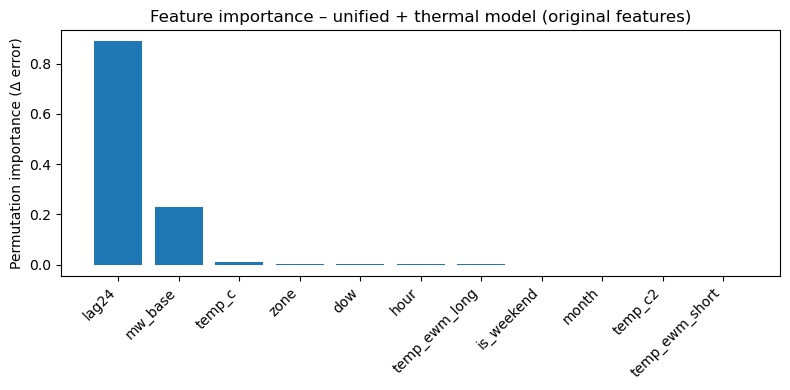

In [34]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# ----- 1) Prepare evaluation data for importance -----
X_eval_imp = global_eval[feature_cols_global]  # original input features to the pipeline
y_eval_imp = global_eval[target_col]

# ----- 2) Permutation importance on the unified + thermal model -----
# This shuffles each *original* feature column and measures RMSE degradation.
print("Computing permutation importance for unified + thermal model (this can take a bit)...")
perm = permutation_importance(
    global_model_thermal,
    X_eval_imp,
    y_eval_imp,
    n_repeats=5,
    random_state=0,
    n_jobs=-1,
)

# Attach importances to the original feature names
imp_df = pd.DataFrame({
    "feature": X_eval_imp.columns,
    "importance": perm.importances_mean,
    "std": perm.importances_std,
}).sort_values("importance", ascending=False)

print("Permutation importances (original features):")
display(imp_df)

# (Optional) If you want a slightly “grouped” view, we can just copy feature -> variable
imp_df["variable"] = imp_df["feature"]

group_imp = (
    imp_df.groupby("variable")["importance"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# ----- 3) Bar plot of importances -----
plt.figure(figsize=(8, 4))
plt.bar(group_imp["variable"], group_imp["importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Permutation importance (Δ error)")
plt.title("Feature importance – unified + thermal model (original features)")
plt.tight_layout()
plt.show()


### GP with matern kernel

Fitting GP for zone: AECO
Subsampled GP training points: 3000
Fitting GP...
Predicting on eval window...
GP RMSE for zone AECO: 64.68
Baseline RMSE (regular week) for AECO: 83.74
Unified + thermal RMSE for AECO:   80.12


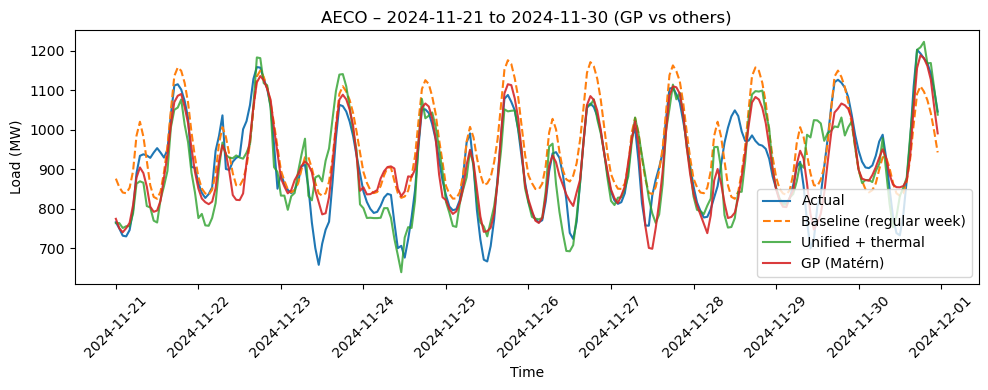

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# ========= 1) Choose a zone for GP (change if you like) =========
zone_for_gp = sorted(global_train["zone"].unique())[0]
print("Fitting GP for zone:", zone_for_gp)

# Use the same numeric features (including thermal inertia)
gp_features = [
    "hour",
    "dow",
    "month",
    "is_weekend",
    "temp_c",
    "temp_c2",
    "lag24",
    "mw_base",
    "temp_ewm_short",
    "temp_ewm_long",
]

train_z = global_train[global_train["zone"] == zone_for_gp].copy()
eval_z  = global_eval[global_eval["zone"] == zone_for_gp].copy()

X_train_gp = train_z[gp_features]
y_train_gp = train_z["mw"]

X_eval_gp = eval_z[gp_features]
y_eval_gp_true = eval_z["mw"]

# ========= 2) Subsample training data (GP is O(n^3)) =========
n_max = 3000
if len(train_z) > n_max:
    train_z_sub = train_z.sample(n_max, random_state=0)
    X_train_gp = train_z_sub[gp_features]
    y_train_gp = train_z_sub["mw"]
    print(f"Subsampled GP training points: {len(X_train_gp)}")
else:
    print(f"GP training points: {len(X_train_gp)}")

# ========= 3) Standardize features =========
scaler_gp = StandardScaler()
X_train_gp_scaled = scaler_gp.fit_transform(X_train_gp)
X_eval_gp_scaled  = scaler_gp.transform(X_eval_gp)

# ========= 4) Define GP with Matérn kernel =========
kernel = ConstantKernel(1.0, (0.1, 10.0)) * Matern(length_scale=1.0, nu=1.5) \
         + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))

gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=2,
    random_state=0,
)

print("Fitting GP...")
gpr.fit(X_train_gp_scaled, y_train_gp)

print("Predicting on eval window...")
y_eval_gp_pred, y_eval_gp_std = gpr.predict(X_eval_gp_scaled, return_std=True)

rmse_gp = root_mean_squared_error(y_eval_gp_true, y_eval_gp_pred)
print(f"GP RMSE for zone {zone_for_gp}: {rmse_gp:.2f}")

# ========= 5) Compare to baseline & unified+thermal for this zone =========
zone_mask = (eval_compare["zone"] == zone_for_gp)
eval_zone = eval_compare.loc[zone_mask].copy()

rmse_base_z = root_mean_squared_error(eval_zone["mw_true"], eval_zone["mw_base"])
rmse_glob_th_z = root_mean_squared_error(eval_zone["mw_true"], eval_zone["mw_pred_global_thermal"])

print(f"Baseline RMSE (regular week) for {zone_for_gp}: {rmse_base_z:.2f}")
print(f"Unified + thermal RMSE for {zone_for_gp}:   {rmse_glob_th_z:.2f}")

# ========= 6) Plot Actual vs Baseline vs Unified+Thermal vs GP =========
eval_zone = eval_zone.sort_values(["date", "hour"]).copy()
eval_zone["timestamp"] = (
    pd.to_datetime(eval_zone["date"].astype(str))
    + pd.to_timedelta(eval_zone["hour"], unit="h")
)

# Align GP preds with eval_zone ordering
# (X_eval_gp and eval_zone rows are aligned by construction through eval_z)
eval_zone["mw_gp"] = y_eval_gp_pred

plt.figure(figsize=(10, 4))
plt.plot(eval_zone["timestamp"], eval_zone["mw_true"], label="Actual")
plt.plot(eval_zone["timestamp"], eval_zone["mw_base"], label="Baseline (regular week)", linestyle="--")
plt.plot(eval_zone["timestamp"], eval_zone["mw_pred_global_thermal"], label="Unified + thermal", alpha=0.8)
plt.plot(eval_zone["timestamp"], eval_zone["mw_gp"], label="GP (Matérn)", alpha=0.9)
plt.title(f"{zone_for_gp} – {PREDICT_START} to {PREDICT_END} (GP vs others)")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Add lag 168 hours

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ============================================================
# 0) Add lag168 using train+eval together so eval keeps full window
# ============================================================

combined = pd.concat(
    [
        train_with_temp_lag_base.assign(_where="train"),
        eval_with_temp_lag_base.assign(_where="eval"),
    ],
    ignore_index=True,
)

combined = combined.sort_values(["zone", "timestamp"]).copy()
combined["lag168"] = combined.groupby("zone")["mw"].shift(168)

train_with_temp_lag_base = combined[combined["_where"] == "train"].drop(columns=["_where"])
eval_with_temp_lag_base  = combined[combined["_where"] == "eval"].drop(columns=["_where"])

print("Eval lag168 NA frac:", eval_with_temp_lag_base["lag168"].isna().mean())

# ============================================================
# 1) Build global design matrix with thermal inertia features
#    (now includes lag168)
# ============================================================

# Start from lag+baseline versions and drop rows with missing key features
global_train = train_with_temp_lag_base.dropna(subset=["temp_c", "lag24", "lag168", "mw_base"]).copy()
global_eval  = eval_with_temp_lag_base.dropna(subset=["temp_c", "lag24", "lag168", "mw_base"]).copy()

# Basic calendar + temp features
for df in (global_train, global_eval):
    ts = df["timestamp"]
    df["hour"] = ts.dt.hour
    df["dow"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
    df["temp_c2"] = df["temp_c"] ** 2

# Thermal inertia: short-term vs long-term EWMA per zone
# - short: span=12  -> reacts to recent ~half-day changes
# - long:  span=72  -> smoother, captures multi-day regime
def add_thermal_inertia(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(["zone", "timestamp"]).copy()
    df["temp_ewm_short"] = (
        df.groupby("zone")["temp_c"]
        .transform(lambda s: s.ewm(span=12, min_periods=1).mean())
    )
    df["temp_ewm_long"] = (
        df.groupby("zone")["temp_c"]
        .transform(lambda s: s.ewm(span=72, min_periods=1).mean())
    )
    return df

global_train = add_thermal_inertia(global_train)
global_eval  = add_thermal_inertia(global_eval)

num_features = [
    "hour",
    "dow",
    "month",
    "is_weekend",
    "temp_c",
    "temp_c2",
    "lag24",
    "lag168",          # <-- new predictor
    "mw_base",
    "temp_ewm_short",
    "temp_ewm_long",
]
cat_features = ["zone"]
feature_cols_global = num_features + cat_features
target_col = "mw"

X_train = global_train[feature_cols_global]
y_train = global_train[target_col]

X_eval = global_eval[feature_cols_global]
y_eval_true = global_eval[target_col]

# ============================================================
# 2) Unified model: OneHotEncoder(zone, dense) + HGBR
# ============================================================

# If your sklearn is older, use OneHotEncoder(..., sparse=False) instead
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", ohe, cat_features),
    ]
)

global_model_thermal = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("reg", HistGradientBoostingRegressor(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            random_state=0,
        )),
    ]
)

global_model_thermal.fit(X_train, y_train)
y_eval_pred_global_th = global_model_thermal.predict(X_eval)

# ============================================================
# 3) Merge unified+thermal preds into eval_compare, compute RMSE
# ============================================================

# Attach unified+thermal predictions by (date, hour, zone)
pred_global_th_df = global_eval[["date", "hour", "zone"]].copy()
pred_global_th_df["mw_pred_global_thermal"] = y_eval_pred_global_th

# Drop if old column exists
if "mw_pred_global_thermal" in eval_compare.columns:
    eval_compare = eval_compare.drop(columns=["mw_pred_global_thermal"])

eval_compare = eval_compare.merge(
    pred_global_th_df,
    on=["date", "hour", "zone"],
    how="inner",
)

# RMSEs using root_mean_squared_error
rmse_base    = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_base"])
rmse_old     = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_old"])
rmse_new     = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_new"])
rmse_glob    = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_global"])
rmse_glob_th = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_global_thermal"])

print("RMSE baseline (regular-week):                    ", rmse_base)
print("RMSE per-zone OLD (no lag, no base):             ", rmse_old)
print("RMSE per-zone NEW (+lag24 + mw_base):            ", rmse_new)
print("RMSE unified model (global + zone OH):           ", rmse_glob)
print("RMSE unified + thermal inertia (+lag24+lag168):  ", rmse_glob_th)

# ============================================================
# 4) Update eval_plot_df and plotting function
# ============================================================

eval_plot_df = eval_compare.copy()
eval_plot_df["timestamp"] = (
    pd.to_datetime(eval_plot_df["date"].astype(str))
    + pd.to_timedelta(eval_plot_df["hour"], unit="h")
)

def plot_zone_eval(zone: str, df: pd.DataFrame = eval_plot_df) -> None:
    """
    Plot actual vs baseline vs per-zone OLD vs per-zone NEW vs unified models
    (with and without thermal inertia) for a single zone over the 10-day window.
    """
    sub = df[df["zone"] == zone].sort_values("timestamp")
    if sub.empty:
        print(f"No data for zone {zone}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(sub["timestamp"], sub["mw_true"], label="Actual")
    plt.plot(sub["timestamp"], sub["mw_base"], label="Baseline (regular week)", linestyle="--")
    plt.plot(sub["timestamp"], sub["mw_pred_old"], label="Per-zone OLD", alpha=0.8)
    plt.plot(sub["timestamp"], sub["mw_pred_new"], label="Per-zone NEW (+lag24+base)", alpha=0.8)
    if "mw_pred_global" in sub.columns:
        plt.plot(sub["timestamp"], sub["mw_pred_global"], label="Unified (global+zone OH)", alpha=0.8)
    plt.plot(sub["timestamp"], sub["mw_pred_global_thermal"], label="Unified + thermal + lag168", alpha=0.9)
    plt.title(f"{zone} – {PREDICT_START} to {PREDICT_END}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: plot all zones
zones = sorted(eval_plot_df["zone"].unique())
# for z in zones:
#     plot_zone_eval(z)


Eval lag168 NA frac: 0.0
RMSE baseline (regular-week):                     399.6861320745404
RMSE per-zone OLD (no lag, no base):              375.0896960363357
RMSE per-zone NEW (+lag24 + mw_base):             279.60544767712594
RMSE unified model (global + zone OH):            287.8927997382692
RMSE unified + thermal inertia (+lag24+lag168):   282.8287125306821


### Add lag_thanksgiving

In [37]:
from datetime import timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ============================================================
# 0) Build Thanksgiving-aligned pattern per zone
# ============================================================

def build_thanksgiving_pattern(train_df: pd.DataFrame,
                               actuals_full_df: pd.DataFrame,
                               train_end_year: int):
    """
    Build a per-zone average load pattern aligned to the Thursday before Thanksgiving.
    For each year:
        align_start = Thanksgiving(year) - 7 days
        take a 14-day window [align_start, align_start+14d]
        compute 'hours_from_thu' = hours since align_start
    Return dict: (zone, hours_from_thu) -> mean load across years.
    """
    all_slices = []

    years = list(range(2017, PREDICT_YEAR + 1))  # e.g. 2017–2024
    for year in years:
        if year <= train_end_year:
            src = train_df[train_df["timestamp"].dt.year == year].copy()
        else:
            src = actuals_full_df[actuals_full_df["timestamp"].dt.year == year].copy()

        if src.empty:
            continue

        # Ensure 'zone' column exists
        if "zone" not in src.columns:
            src["zone"] = src["load_area"]

        tg = thanksgiving_date(year)
        align_start = tg - timedelta(days=7)              # Thursday before Thanksgiving
        start_ts = pd.Timestamp(align_start)
        end_ts   = start_ts + pd.Timedelta(days=14)       # 2-week window

        slice_df = src[(src["timestamp"] >= start_ts) & (src["timestamp"] <= end_ts)].copy()
        if slice_df.empty:
            continue

        slice_df["hours_from_thu"] = (
            (slice_df["timestamp"] - start_ts).dt.total_seconds() / 3600.0
        ).astype(int)

        all_slices.append(slice_df[["zone", "hours_from_thu", "mw"]])

    if not all_slices:
        raise RuntimeError("No Thanksgiving slices found to build pattern.")

    slices_cat = pd.concat(all_slices, ignore_index=True)
    pattern = (
        slices_cat.groupby(["zone", "hours_from_thu"])["mw"]
        .mean()
        .to_dict()
    )
    return pattern

thank_pattern = build_thanksgiving_pattern(train_df, actuals_full_df, TRAIN_END.year)

# ============================================================
# 1) Add lag_thanksgiving to train_with_temp_lag_base & eval_with_temp_lag_base
# ============================================================

def add_thanksgiving_feature(df: pd.DataFrame,
                             pattern: dict) -> pd.DataFrame:
    """
    For each row, compute the hour offset from the Thursday before Thanksgiving
    in that year, then look up the average pattern in 'pattern'.
    If not found (outside the 2-week window), fall back to mw_base.
    """
    df = df.copy()

    years = df["timestamp"].dt.year.unique()
    align_starts = {y: thanksgiving_date(y) - timedelta(days=7) for y in years}

    df["align_start"] = df["timestamp"].dt.year.map(align_starts).astype("datetime64[ns]")
    df["hours_from_thu"] = (
        (df["timestamp"] - df["align_start"]).dt.total_seconds() / 3600.0
    ).astype(int)

    # Vectorized lookup via a Series with MultiIndex
    pattern_series = pd.Series(pattern)
    idx = list(zip(df["zone"], df["hours_from_thu"]))
    df["lag_thanksgiving_raw"] = pattern_series.reindex(idx).to_numpy()

    # Fallback: if we don't have a pattern value, use mw_base (regular week)
    df["lag_thanksgiving"] = df["lag_thanksgiving_raw"]
    missing = df["lag_thanksgiving"].isna()
    df.loc[missing, "lag_thanksgiving"] = df.loc[missing, "mw_base"]

    df = df.drop(columns=["align_start", "hours_from_thu", "lag_thanksgiving_raw"])
    return df

train_with_temp_lag_base = add_thanksgiving_feature(train_with_temp_lag_base, thank_pattern)
eval_with_temp_lag_base  = add_thanksgiving_feature(eval_with_temp_lag_base, thank_pattern)

# Quick sanity check
print("Train lag_thanksgiving missing fraction:",
      train_with_temp_lag_base["lag_thanksgiving"].isna().mean())
print("Eval  lag_thanksgiving missing fraction:",
      eval_with_temp_lag_base["lag_thanksgiving"].isna().mean())

# ============================================================
# 2) Build global design matrix with thermal + lags + lag_thanksgiving
# ============================================================

# Start from lag+baseline versions and drop rows with missing key features
global_train = train_with_temp_lag_base.dropna(
    subset=["temp_c", "lag24", "lag168", "mw_base", "lag_thanksgiving"]
).copy()
global_eval  = eval_with_temp_lag_base.dropna(
    subset=["temp_c", "lag24", "lag168", "mw_base", "lag_thanksgiving"]
).copy()

# Basic calendar + temp features
for df in (global_train, global_eval):
    ts = df["timestamp"]
    df["hour"] = ts.dt.hour
    df["dow"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
    df["temp_c2"] = df["temp_c"] ** 2

# Thermal inertia (short/long EWMAs of temp) per zone
def add_thermal_inertia(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(["zone", "timestamp"]).copy()
    df["temp_ewm_short"] = (
        df.groupby("zone")["temp_c"]
        .transform(lambda s: s.ewm(span=12, min_periods=1).mean())
    )
    df["temp_ewm_long"] = (
        df.groupby("zone")["temp_c"]
        .transform(lambda s: s.ewm(span=72, min_periods=1).mean())
    )
    return df

global_train = add_thermal_inertia(global_train)
global_eval  = add_thermal_inertia(global_eval)

num_features = [
    "hour",
    "dow",
    "month",
    "is_weekend",
    "temp_c",
    "temp_c2",
    "lag24",
    "lag168",
    "mw_base",
    "lag_thanksgiving",   # <-- new predictor
    "temp_ewm_short",
    "temp_ewm_long",
]
cat_features = ["zone"]
feature_cols_global = num_features + cat_features
target_col = "mw"

X_train = global_train[feature_cols_global]
y_train = global_train[target_col]

X_eval = global_eval[feature_cols_global]
y_eval_true = global_eval[target_col]

# ============================================================
# 3) Unified model: OneHotEncoder(zone, dense) + HGBR
# ============================================================

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", ohe, cat_features),
    ]
)

global_model_thank = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("reg", HistGradientBoostingRegressor(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            random_state=0,
        )),
    ]
)

global_model_thank.fit(X_train, y_train)
y_eval_pred_global_thank = global_model_thank.predict(X_eval)

# ============================================================
# 4) Merge unified+thanksgiving preds into eval_compare, compute RMSE
# ============================================================

pred_global_thank_df = global_eval[["date", "hour", "zone"]].copy()
pred_global_thank_df["mw_pred_global_thank"] = y_eval_pred_global_thank

if "mw_pred_global_thank" in eval_compare.columns:
    eval_compare = eval_compare.drop(columns=["mw_pred_global_thank"])

eval_compare = eval_compare.merge(
    pred_global_thank_df,
    on=["date", "hour", "zone"],
    how="inner",
)

rmse_base       = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_base"])
rmse_old        = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_old"])
rmse_new        = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_new"])
rmse_glob       = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_global"])
rmse_glob_th    = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_global_thermal"])
# rmse_glob_l168  = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_global_lag168"])
rmse_glob_thank = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_global_thank"])

print("RMSE baseline (regular-week):                        ", rmse_base)
print("RMSE per-zone OLD (no lag, no base):                 ", rmse_old)
print("RMSE per-zone NEW (+lag24 + mw_base):                ", rmse_new)
print("RMSE unified (old global):                           ", rmse_glob)
print("RMSE unified + thermal (lag24 + mw_base + EWM):      ", rmse_glob_th)
# print("RMSE unified + thermal + lag168:                     ", rmse_glob_l168)
print("RMSE unified + thermal + lag168 + lag_thanksgiving:  ", rmse_glob_thank)

# ============================================================
# 5) Update eval_plot_df and plotting function
# ============================================================

eval_plot_df = eval_compare.copy()
eval_plot_df["timestamp"] = (
    pd.to_datetime(eval_plot_df["date"].astype(str))
    + pd.to_timedelta(eval_plot_df["hour"], unit="h")
)

def plot_zone_eval(zone: str, df: pd.DataFrame = eval_plot_df) -> None:
    """
    Plot actual vs baseline vs per-zone OLD/NEW vs unified models
    including the Thanksgiving-pattern predictor.
    """
    sub = df[df["zone"] == zone].sort_values("timestamp")
    if sub.empty:
        print(f"No data for zone {zone}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(sub["timestamp"], sub["mw_true"], label="Actual")
    plt.plot(sub["timestamp"], sub["mw_base"], label="Baseline (regular week)", linestyle="--")
    plt.plot(sub["timestamp"], sub["mw_pred_old"], label="Per-zone OLD", alpha=0.8)
    plt.plot(sub["timestamp"], sub["mw_pred_new"], label="Per-zone NEW (+lag24+base)", alpha=0.8)
    if "mw_pred_global" in sub.columns:
        plt.plot(sub["timestamp"], sub["mw_pred_global"], label="Unified (old global)", alpha=0.6)
    if "mw_pred_global_lag168" in sub.columns:
        plt.plot(sub["timestamp"], sub["mw_pred_global_lag168"], label="Unified + thermal + lag168", alpha=0.7)
    plt.plot(sub["timestamp"], sub["mw_pred_global_thank"], label="Unified + Thanksgiving pattern", alpha=0.9)
    plt.title(f"{zone} – {PREDICT_START} to {PREDICT_END}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: plot all zones
zones = sorted(eval_plot_df["zone"].unique())
# for z in zones:
#     plot_zone_eval(z)


Train lag_thanksgiving missing fraction: 0.0
Eval  lag_thanksgiving missing fraction: 0.0
RMSE baseline (regular-week):                         399.6861320745404
RMSE per-zone OLD (no lag, no base):                  375.0896960363357
RMSE per-zone NEW (+lag24 + mw_base):                 279.60544767712594
RMSE unified (old global):                            287.8927997382692
RMSE unified + thermal (lag24 + mw_base + EWM):       282.8287125306821
RMSE unified + thermal + lag168 + lag_thanksgiving:   262.4948267024624


In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1) Prepare features for unified GP (all zones, all predictors)
# ============================================================

gp_num_features = [
    "hour",
    "dow",
    "month",
    "is_weekend",
    "temp_c",
    "temp_c2",
    "lag24",
    "lag168",
    "mw_base",
    "lag_thanksgiving",
    "temp_ewm_short",
    "temp_ewm_long",
]

# Use global_train/global_eval that already contain these columns + 'zone' + 'mw'
train_gp_df = global_train[["zone"] + gp_num_features + ["mw"]].copy()
eval_gp_df  = global_eval[["zone"] + gp_num_features + ["mw"]].copy()

# We will keep meta (date/hour/zone) separately for merging later
eval_meta = global_eval[["date", "hour", "zone"]].copy()

# ---- Build zone dummies jointly (train + eval) so columns match ----
comb = pd.concat(
    [
        train_gp_df.assign(_where="train"),
        eval_gp_df.assign(_where="eval"),
    ],
    ignore_index=True,
)

# One-hot encode zone on the combined frame
zone_dummies = pd.get_dummies(comb["zone"], prefix="zone")

# Full feature matrix: numeric + zone dummies
X_all = pd.concat(
    [comb[gp_num_features].reset_index(drop=True),
     zone_dummies.reset_index(drop=True)],
    axis=1,
)

# Split back into train / eval
mask_train = comb["_where"] == "train"
mask_eval  = comb["_where"] == "eval"

X_train_full = X_all[mask_train].reset_index(drop=True)
y_train_full = comb.loc[mask_train, "mw"].to_numpy()

X_eval_full  = X_all[mask_eval].reset_index(drop=True)
y_eval_true_full = comb.loc[mask_eval, "mw"].to_numpy()

print("Unified GP: train shape (full):", X_train_full.shape)
print("Unified GP: eval  shape:", X_eval_full.shape)

# ============================================================
# 2) Subsample training data for GP (GP is O(n^3))
# ============================================================

n_max = 8000  # total training points across all zones for GP
n_train = len(X_train_full)

if n_train > n_max:
    rng = np.random.RandomState(0)
    train_sub_idx = rng.choice(n_train, size=n_max, replace=False)
    X_train_gp = X_train_full.iloc[train_sub_idx].to_numpy()
    y_train_gp = y_train_full[train_sub_idx]
    print(f"Unified GP: subsampled training points: {len(X_train_gp)} (of {n_train})")
else:
    X_train_gp = X_train_full.to_numpy()
    y_train_gp = y_train_full
    print(f"Unified GP: using all training points: {len(X_train_gp)}")

X_eval_gp = X_eval_full.to_numpy()
y_eval_gp_true = y_eval_true_full

# ============================================================
# 3) Standardize features
# ============================================================

scaler_gp = StandardScaler()
X_train_gp_scaled = scaler_gp.fit_transform(X_train_gp)
X_eval_gp_scaled  = scaler_gp.transform(X_eval_gp)

# ============================================================
# 4) Define and fit unified GP with Matérn kernel
# ============================================================

kernel = (
    ConstantKernel(1.0, (0.1, 10.0))
    * Matern(length_scale=1.0, nu=1.5)
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))
)

gpr_unified = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=2,
    random_state=0,
)

print("Fitting unified GP (this may take a bit)...")
gpr_unified.fit(X_train_gp_scaled, y_train_gp)
print("Optimized kernel:", gpr_unified.kernel_)

print("Predicting unified GP on eval window...")
y_eval_gp_pred, y_eval_gp_std = gpr_unified.predict(X_eval_gp_scaled, return_std=True)

rmse_gp_unified = root_mean_squared_error(y_eval_gp_true, y_eval_gp_pred)
print(f"Unified GP RMSE (all zones, eval window): {rmse_gp_unified:.2f}")

# ============================================================
# 5) Merge unified GP predictions into eval_compare
# ============================================================

gp_pred_df = eval_meta.copy()
gp_pred_df["mw_pred_gp_unified"] = y_eval_gp_pred

if "mw_pred_gp_unified" in eval_compare.columns:
    eval_compare = eval_compare.drop(columns=["mw_pred_gp_unified"])

eval_compare = eval_compare.merge(
    gp_pred_df,
    on=["date", "hour", "zone"],
    how="inner",
)

rmse_base = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_base"])
print("RMSE baseline (regular-week):                  ", rmse_base)

if "mw_pred_global_thank" in eval_compare.columns:
    rmse_thank = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_global_thank"])
    print("RMSE unified + thermal + Thanksgiving pattern:", rmse_thank)

rmse_gp_unified_check = root_mean_squared_error(eval_compare["mw_true"], eval_compare["mw_pred_gp_unified"])
print("RMSE unified GP (Matérn, subsampled):          ", rmse_gp_unified_check)

# ============================================================
# 6) Update eval_plot_df and plotting function to include GP
# ============================================================

eval_plot_df = eval_compare.copy()
eval_plot_df["timestamp"] = (
    pd.to_datetime(eval_plot_df["date"].astype(str))
    + pd.to_timedelta(eval_plot_df["hour"], unit="h")
)

def plot_zone_eval(zone: str, df: pd.DataFrame = eval_plot_df) -> None:
    """
    Plot actual vs baseline vs per-zone OLD/NEW vs unified models
    including unified GP for a single zone over the eval window.
    """
    sub = df[df["zone"] == zone].sort_values("timestamp")
    if sub.empty:
        print(f"No data for zone {zone}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(sub["timestamp"], sub["mw_true"], label="Actual")
    plt.plot(sub["timestamp"], sub["mw_base"], label="Baseline (regular week)", linestyle="--")
    plt.plot(sub["timestamp"], sub["mw_pred_old"], label="Per-zone OLD", alpha=0.7)
    plt.plot(sub["timestamp"], sub["mw_pred_new"], label="Per-zone NEW (+lag24+base)", alpha=0.7)

    if "mw_pred_global_thank" in sub.columns:
        plt.plot(sub["timestamp"], sub["mw_pred_global_thank"],
                 label="Unified + thermal + Thanksgiving", alpha=0.8)

    plt.plot(sub["timestamp"], sub["mw_pred_gp_unified"],
             label="Unified GP (Matérn, subsampled)", alpha=0.9)

    plt.title(f"{zone} – {PREDICT_START} to {PREDICT_END}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: plot a couple of zones:
for z in sorted(eval_plot_df["zone"].unique())[:3]:
    plot_zone_eval(z)


Unified GP: train shape (full): (757462, 41)
Unified GP: eval  shape: (6960, 41)
Unified GP: subsampled training points: 8000 (of 757462)
Fitting unified GP (this may take a bit)...


KeyboardInterrupt: 

## Prediction - 2025 Nov 20-29

In [39]:
from datetime import date, datetime, timedelta
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# ============================================================
# 1) Set up training data for forecast GP (2021–2024)
# ============================================================

# We reuse global_train/global_eval, but restrict by year
def year_from_ts(ts):
    return ts.dt.year

train_mask_21_24 = (global_train["timestamp"].dt.year >= 2021) & (global_train["timestamp"].dt.year <= 2024)
gp_train_df = global_train.loc[train_mask_21_24].copy()

# If you want to also include the 2024 eval window as extra training:
if "timestamp" in global_eval.columns:
    eval_mask_24 = (global_eval["timestamp"].dt.year == 2024)
    gp_train_df = pd.concat([gp_train_df, global_eval.loc[eval_mask_24].copy()], ignore_index=True)

print("GP forecast training rows:", len(gp_train_df))

# Numeric features to use (same as earlier unified GP)
gp_num_features = [
    "hour",
    "dow",
    "month",
    "is_weekend",
    "temp_c",
    "temp_c2",
    "lag24",
    "lag168",
    "mw_base",
    "lag_thanksgiving",
    "temp_ewm_short",
    "temp_ewm_long",
]

# Build combined frame for GP training: numeric + zone dummies
gp_train_small = gp_train_df[["zone"] + gp_num_features + ["mw"]].copy()

comb_train = gp_train_small.copy()
zone_dummies_train = pd.get_dummies(comb_train["zone"], prefix="zone")
X_train_full = pd.concat(
    [comb_train[gp_num_features].reset_index(drop=True),
     zone_dummies_train.reset_index(drop=True)],
    axis=1,
)
y_train_full = comb_train["mw"].to_numpy()

zone_dummy_cols = list(zone_dummies_train.columns)  # keep for future one-hot

print("Unified forecast GP: train X shape:", X_train_full.shape)

# Standardize
scaler_gp_forecast = StandardScaler()
X_train_scaled = scaler_gp_forecast.fit_transform(X_train_full.to_numpy())

# Define + fit GP
kernel_forecast = (
    ConstantKernel(1.0, (0.1, 10.0))
    * Matern(length_scale=1.0, nu=1.5)
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))
)

gpr_forecast = GaussianProcessRegressor(
    kernel=kernel_forecast,
    normalize_y=True,
    n_restarts_optimizer=2,
    random_state=0,
)

print("Fitting forecast GP (2021–2024)...")
gpr_forecast.fit(X_train_scaled, y_train_full)
print("Forecast GP optimized kernel:", gpr_forecast.kernel_)

# ============================================================
# 2) Load Nov 2025 metered data (up to Nov 13)
# ============================================================

nov_2025_path = METERED_DIR / "hrl_load_metered_nov.txt"
nov2025_raw = pd.read_csv(nov_2025_path)

# Adjust format string if needed
nov2025_raw["timestamp"] = pd.to_datetime(
    nov2025_raw["datetime_beginning_ept"],
    format="%m/%d/%Y %I:%M:%S %p",
)
nov2025_raw["date"] = nov2025_raw["timestamp"].dt.date
nov2025_raw["hour"] = nov2025_raw["timestamp"].dt.hour

nov2025 = nov2025_raw[
    (nov2025_raw["date"] >= date(2025, 11, 1)) &
    (nov2025_raw["date"] <= date(2025, 11, 13))
].copy()

nov2025 = nov2025.rename(columns={"load_area": "zone"})
nov2025 = nov2025[["zone", "timestamp", "date", "hour", "mw"]].copy()

print("Nov 2025 observed rows (up to 13th):", len(nov2025))

# ============================================================
# 3) Build future grid (Nov 1–29, 2025) per zone with weather + baseline
# ============================================================

forecast_start = pd.Timestamp("2025-11-20 00:00:00")
forecast_end   = pd.Timestamp("2025-11-29 23:00:00")

# Build full hourly index for Nov 1–29
full_hours = pd.date_range("2025-11-01 00:00:00", "2025-11-29 23:00:00", freq="H")

zones = sorted(train_df["load_area"].unique())
future_rows = []
for z in zones:
    for ts in full_hours:
        future_rows.append({"zone": z, "timestamp": ts})

future_df = pd.DataFrame(future_rows)
future_df["date"] = future_df["timestamp"].dt.date
future_df["hour"] = future_df["timestamp"].dt.hour

# Attach observed Nov 1–13 mw where available
future_df = future_df.merge(
    nov2025[["zone", "timestamp", "mw"]],
    on=["zone", "timestamp"],
    how="left",
)

# Attach weather for 2025-11
weather_2025 = weather_df[
    (weather_df["date"] >= date(2025, 11, 1)) &
    (weather_df["date"] <= date(2025, 11, 30))
].copy()
future_df = future_df.merge(
    weather_2025[["zone", "timestamp", "temp_c"]],
    on=["zone", "timestamp"],
    how="left",
)

# Add baseline + Thanksgiving pattern + thermal inertia
future_df = add_baseline_feature(future_df)               # adds mw_base
future_df = add_thanksgiving_feature(future_df, thank_pattern)
future_df = add_thermal_inertia(future_df)               # uses temp_c

# ============================================================
# 4) Fill Nov 14–19 with baseline, prepare lag containers
# ============================================================

# For 14–19, if mw is missing, use baseline as filler
mask_gap = (
    (future_df["date"] >= date(2025, 11, 14)) &
    (future_df["date"] <= date(2025, 11, 19)) &
    (future_df["mw"].isna())
)
future_df.loc[mask_gap, "mw"] = future_df.loc[mask_gap, "mw_base"]

# We'll maintain a dict for quick mw lookup per (zone, timestamp)
# Initialize with all known/filler values up through Nov 19
mw_lookup = {}

for _, row in future_df.iterrows():
    ts = row["timestamp"]
    if ts <= pd.Timestamp("2025-11-19 23:00:00"):
        mw_lookup[(row["zone"], ts)] = row["mw"]

# ============================================================
# 5) Sequential forecast for Nov 20–29 using forecast GP
# ============================================================

def make_gp_features_for_timestamp(row, mw_lookup, zone_dummy_cols):
    """
    Build the GP feature vector for one (zone, timestamp) row, using
    lag24 and lag168 from mw_lookup, and all the other engineered features
    already in future_df.
    """
    z = row["zone"]
    ts = row["timestamp"]

    # lag24, lag168: use mw_lookup; fall back to mw_base if missing
    ts_lag24  = ts - pd.Timedelta(hours=24)
    ts_lag168 = ts - pd.Timedelta(hours=168)

    lag24_val = mw_lookup.get((z, ts_lag24), row["mw_base"])
    lag168_val = mw_lookup.get((z, ts_lag168), row["mw_base"])

    # numeric features
    num_vals = [
        row["hour"],
        row["timestamp"].dayofweek,
        row["timestamp"].month,
        1 if row["timestamp"].dayofweek in [5, 6] else 0,
        row["temp_c"],
        row["temp_c"] ** 2,
        lag24_val,
        lag168_val,
        row["mw_base"],
        row["lag_thanksgiving"],
        row["temp_ewm_short"],
        row["temp_ewm_long"],
    ]

    # zone one-hot: same columns as training
    zone_dummy = pd.Series(0.0, index=zone_dummy_cols)
    colname = f"zone_{z}"
    if colname in zone_dummy.index:
        zone_dummy[colname] = 1.0

    feat = np.concatenate([np.array(num_vals, dtype=float), zone_dummy.to_numpy()])
    return feat, lag24_val, lag168_val

# We'll store predictions here
pred_rows = []

for z in zones:
    # process all forecast hours for this zone in chronological order
    zone_mask = (
        (future_df["zone"] == z) &
        (future_df["timestamp"] >= forecast_start) &
        (future_df["timestamp"] <= forecast_end)
    )
    zone_future = future_df.loc[zone_mask].sort_values("timestamp").copy()

    for idx, row in zone_future.iterrows():
        feat_vec, lag24_val, lag168_val = make_gp_features_for_timestamp(
            row, mw_lookup, zone_dummy_cols
        )

        # scale + predict
        X_scaled = scaler_gp_forecast.transform(feat_vec.reshape(1, -1))
        mw_pred = gpr_forecast.predict(X_scaled)[0]

        ts = row["timestamp"]
        pred_rows.append(
            {
                "zone": z,
                "timestamp": ts,
                "date": ts.date(),
                "hour": ts.hour,
                "mw_pred_gp_forecast": mw_pred,
            }
        )

        # update mw_lookup so future lags can see this prediction
        mw_lookup[(z, ts)] = mw_pred

# Collect forecast predictions
forecast_pred_df = pd.DataFrame(pred_rows).sort_values(["zone", "timestamp"])
print("Forecast horizon rows:", len(forecast_pred_df))

# Optionally, inspect a few lines
display(forecast_pred_df.head())

# If you want the final contest-style output: one row per (date, hour, zone)
# you can rename / select columns here:
contest_forecast = forecast_pred_df.rename(columns={"zone": "load_area"})
contest_forecast = contest_forecast[["date", "hour", "load_area", "mw_pred_gp_forecast"]]
display(contest_forecast.head())


GP forecast training rows: 764422
Unified forecast GP: train X shape: (764422, 41)
Fitting forecast GP (2021–2024)...


: 